In [2]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import sys
sys.path.append('../Codes/lib/')
from models import *
from Epi_models import*
from functions import *
import networkx as nx
import matplotlib.animation as animation
import seaborn as sns
from matplotlib.lines import Line2D
import pickle

import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as ticker
Text_files_path = '../../../../Dropbox/Research/Epidemiology_2020/Text_files/'

%autosave 60

Autosaving every 60 seconds


# Stochastic simulations on Networks

In [2]:
N = 2000
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
G1 = nx.barabasi_albert_graph(N, 2)
G2 = nx.watts_strogatz_graph(N, 4, 1)

## Network and degree distribution (uncomment to update $k$ and $p_k$)

#----Load data network of contacts----
N = 2000
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
nodeDegrees = np.loadtxt(Text_files_path+'Stochastic/Networks/barabasi-albert/network_degree_distrib_N%d.txt'%(N), dtype=np.int32)
meanDegree = np.mean(nodeDegrees)
meanDegree2 = np.mean(nodeDegrees**2)
degree_distrib = np.histogram(nodeDegrees, bins=np.arange(1, np.max(nodeDegrees)+1), density = False)
k = degree_distrib[1][:-1]
p_k = degree_distrib[0]/len(nodeDegrees)

outfile_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/k.pck','wb')
pickle.dump(k, outfile_k)
outfile_k.close()
outfile_p_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/p_k.pck','wb')
pickle.dump(p_k, outfile_p_k)
outfile_p_k.close()
print(meanDegree, meanDegree2, np.max(nodeDegrees))

In [3]:
infile_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/k.pck','rb')
k = pickle.load(infile_k)
infile_k.close()
infile_p_k = open(Text_files_path+'Stochastic/Networks/barabasi-albert/p_k.pck','rb')
p_k = pickle.load(infile_p_k)
infile_p_k.close()

meanDegree = np.sum(k*p_k)
meanDegree2 = np.sum(k**2*p_k)
print(meanDegree)
print(np.max(k))

3.9960271618768215
265


## Single Trajectory

22.165525060596448 11.999999999999998


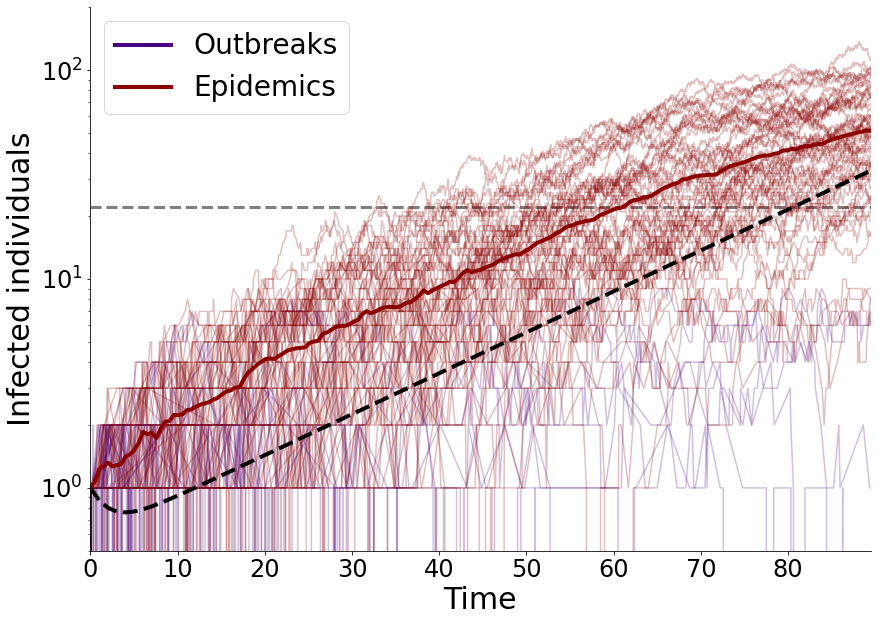

In [81]:
intervals = 100
p=1.0
gamma = 1/6
sigma = 1/4
R0 = 1.5 #use 1.5 and 4.0
beta = R0*gamma
T_total = 90 #use 65 and 12
intervals = T_total*2
repetitions = 200
lambda1 = ((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*beta)
est = 1/(lambda1)
print(est, 1/(beta-gamma))
colors_status = ['indigo', 'darkred']

fig, ax = plt.subplots(figsize=(14,10))

### run function 
G = nx.barabasi_albert_graph(N, 2)
E_avg = np.zeros(shape=(2, intervals))
I_avg = np.zeros(shape=(2, intervals))
n_epi = 0

T_avg = np.linspace(0, T_total, intervals)
for i in np.arange(repetitions):
    t, E_t, I_t, status = run_network_trajectory(N, G, beta, sigma, gamma, T_total, p, initE = 0, initI = 1, folder = Text_files_path +'Stochastic/Networks/'+graphs_names[0], save = False)
    E_avg_temp, I_avg_temp = regularize_time_series(T_total = T_total, intervals = intervals, t = t, E_t = E_t, I_t = I_t)
    E_avg[status, :] += E_avg_temp
    I_avg[status, :] += I_avg_temp
    n_epi += status
    ax.plot(t, I_t, color = colors_status[status], alpha = .25)
    
lambda1, lambda2, time, E_solution, I_solution, sol_total_approx, I_max_2 = run_deterministic(N, beta, sigma, gamma, p, T_total, folder = Text_files_path +'Deterministic/Single_trajectory')
ax.plot(time, I_solution, color = 'black', ls = '--', lw = 4)
ax.plot(T_avg, I_avg[0,:]/(repetitions-n_epi), color = colors_status[0], label = 'Outbreaks', lw = 4)
ax.plot(T_avg, I_avg[1,:]/n_epi, color = colors_status[1], label = 'Epidemics', lw = 4)
#ax.plot(T_avg, (I_avg[0,:]+I_avg[1,:])/(repetitions), color = 'silver', lw = 3)
ax.hlines(est, 0, T_total, color = 'grey', lw = 3, linestyle = '--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom = .5, top = 2e2)
ax.set_xlim(-0.1, T_total-0.5)
my_plot_layout(ax = ax, yscale = 'log', xlabel = 'Time', ylabel = 'Infected individuals', x_fontsize = 30, y_fontsize = 30)
ax.legend(fontsize = 28, loc = 2)

#fig.savefig('../Figures/Stochastic/Networks/'+graphs_names[0]+'/Trajectories/pdfs/figure_trajectories_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma, sigma, N, p)+'.pdf')


## Ensemble

In [32]:
sample_sizes = [150, 250, 400]
colors = ['b', 'g', 'r']
colors2 = ['purple', 'violet', 'brown']
N = 2000
print('N:', N)
gamma = 1/6
print('Gamma:', gamma)
sigma = 1/4
print('Sigma:', sigma)
graphs = [G1]
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
sampling_protocol = np.array(['uniform', 'aposteriori'])
folders  = np.array(['../Figures/Control/Stochastic/Ensemble/Networks/', '../Figures/Stochastic/Networks/'])

ps = np.array([0.0])
#ps = np.array([0.0])
print('ps:',ps)
#n_sims = np.array([100, 100, 100, 100, 100])
n_sims = np.array([100000, 100000, 100000, 100000, 100000])
print('n_sim:',n_sims)

R0s = np.array([1.2, 2.0, 3.0, 4.5])
R0s2 = np.array([0.8, 1.2, 2.0, 3.0, 4.5]) # with network p=0

Betas = np.array([R0s2*gamma,R0s*gamma])
print('Betas:', Betas)

R0_Ns = (R0s2*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0s2))
R0_Es = np.sqrt(1-4*((sigma*gamma-sigma*Betas[0])/(sigma + gamma)**2))
R0_ENs = (R0_Es*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0_Es))

print('R0s:', R0s2)
print('R0_Es:',R0_Es)
print('R0_Ns:',R0_Ns)
print('R0_ENs:',R0_ENs)

lambdas = ((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*Betas[1]) #exponential growth rates

ests = (1/(lambdas)).astype(int)
if(sigma==1/4):
    est_Ns = (1/((R0_ENs-1)*gamma)).astype(int)
if(sigma==1000):
    est_Ns = (1/((R0_Ns-1)*gamma)).astype(int)

Ts_Total = np.array([5*est_Ns,5*ests]) #for R0 = [1.2, 1.5, 3.0, 4.5] use [160, 35, 20] and half of it if when sigma=1000
print('Times:',Ts_Total)
slopes = np.array([1, 1, 1, 1, 1, 1])
print('slopes:',slopes)

aposteriori = False
print('Aposteriori:',aposteriori)

N: 2000
Gamma: 0.16666666666666666
Sigma: 0.25
ps: [0.]
n_sim: [100000 100000 100000 100000 100000]
Betas: [array([0.13333333, 0.2       , 0.33333333, 0.5       , 0.75      ])
 array([0.2       , 0.33333333, 0.5       , 0.75      ])]
R0s: [0.8 1.2 2.  3.  4.5]
R0_Es: [0.8988882  1.09178753 1.4        1.70880075 2.0880613 ]
R0_Ns: [1.80477125 2.49875481 3.60894459 4.63963246 5.7307364 ]
R0_ENs: [1.9868922  2.3217778  2.80716357 3.24087804 3.7133128 ]
Times: [array([30, 20, 15, 10, 10]) array([260,  60,  30,  20])]
slopes: [1 1 1 1 1 1]
Aposteriori: False


In [33]:
%%time
##Run over values of p
for p, Ts_total, betas in zip (ps, Ts_Total, Betas):
    ##Run over graphs
    for G, G_name in zip(graphs, graphs_names):
        ##Run over R0s
        for beta, T_total, slope, n_sim in zip (betas, Ts_total, slopes, n_sims):
            print('T:', T_total )
            print('p:',p)
            print('R0:', beta/gamma)
            if(aposteriori):
                print('slope:',slope)
            print('Succ nodes:')
            ### Generate new graph
            G = nx.barabasi_albert_graph(N, 2)
            ### run function 
            %time run_network_ensemble(N=N, G=G, G_name=G_name, beta=beta, sigma=sigma, gamma=gamma, T_total=T_total, intervals=T_total+1, n_ensemble=n_sim, p = p, initE=0, initI=1, folder ='../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/'+G_name+'/k_normalization', stochastic = True, sampling = False, sample_sizes = sample_sizes, aposteriori=aposteriori, slope = slope)
            print('\n')
            

T: 30
p: 0.0
R0: 0.8
Succ nodes:
100000
CPU times: user 1h 6min 42s, sys: 2min 50s, total: 1h 9min 33s
Wall time: 1h 9min 37s


T: 20
p: 0.0
R0: 1.2
Succ nodes:
1
CPU times: user 1h 8min 2s, sys: 2min 59s, total: 1h 11min 2s
Wall time: 1h 11min 6s


T: 15
p: 0.0
R0: 2.0
Succ nodes:
1144
CPU times: user 1h 9min 44s, sys: 3min 17s, total: 1h 13min 1s
Wall time: 1h 13min 9s


T: 10
p: 0.0
R0: 3.0
Succ nodes:
5360
CPU times: user 1h 10min, sys: 3min 12s, total: 1h 13min 13s
Wall time: 1h 13min 18s


T: 10
p: 0.0
R0: 4.5
Succ nodes:
18514
CPU times: user 1h 13min 15s, sys: 3min 19s, total: 1h 16min 34s
Wall time: 1h 16min 40s


CPU times: user 5h 47min 45s, sys: 15min 40s, total: 6h 3min 26s
Wall time: 6h 3min 53s


195 1 3.996 46.88504867256637


## Successful Nodes

[1.00006664 1.0011656 ]
epi_nodes $(p=1.0 ; R_0=1.2)$ : 2425
epi_nodes $(p=1.0 ; R_0=4.5)$ : 7543
epi_nodes $(p=0.0 ; R_0=1.2)$ : 2885
epi_nodes $(p=0.0 ; R_0=4.5)$ : 13019
[-2.11054921 36.85231752]


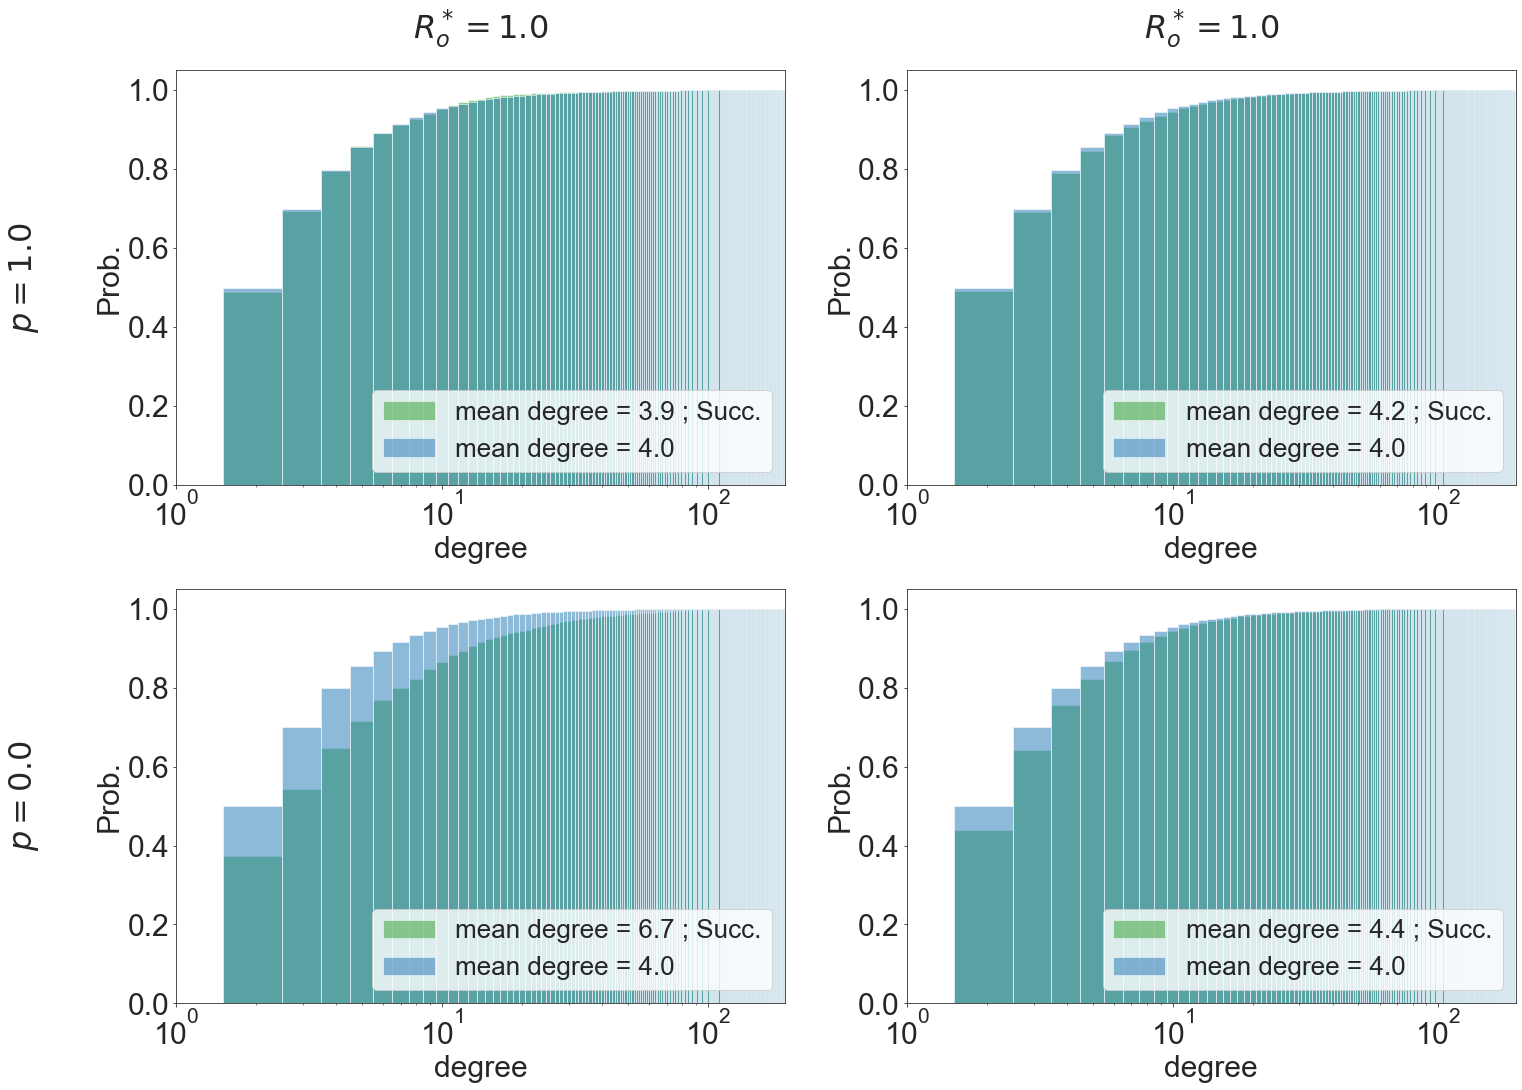

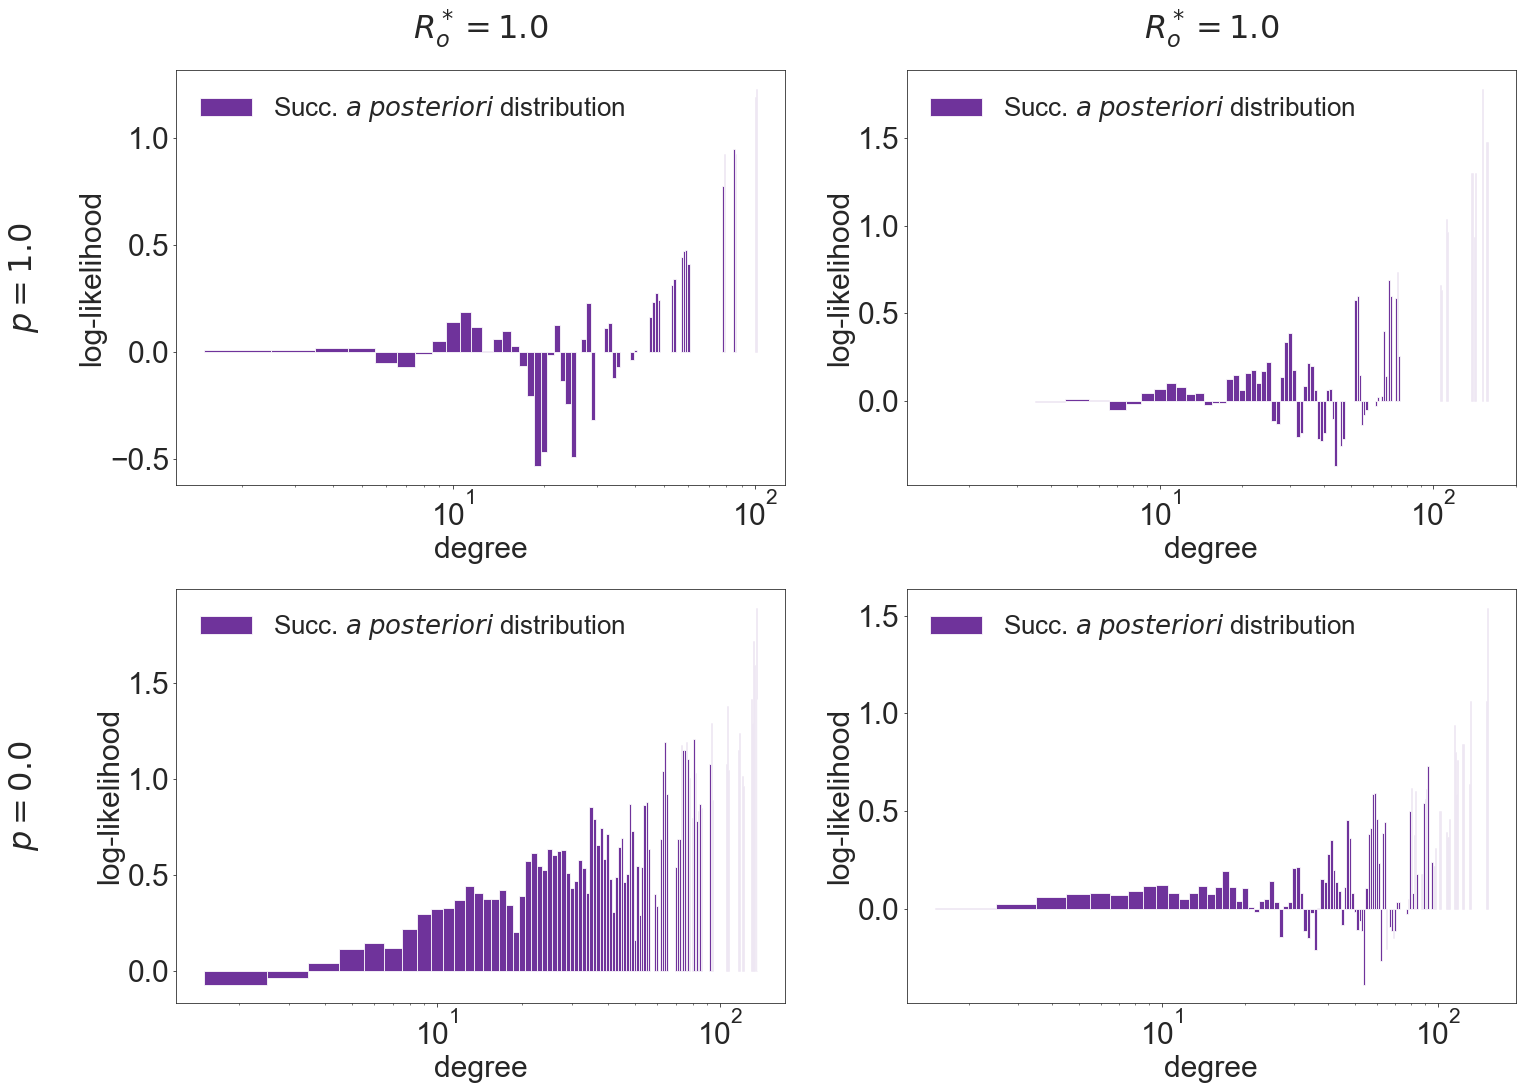

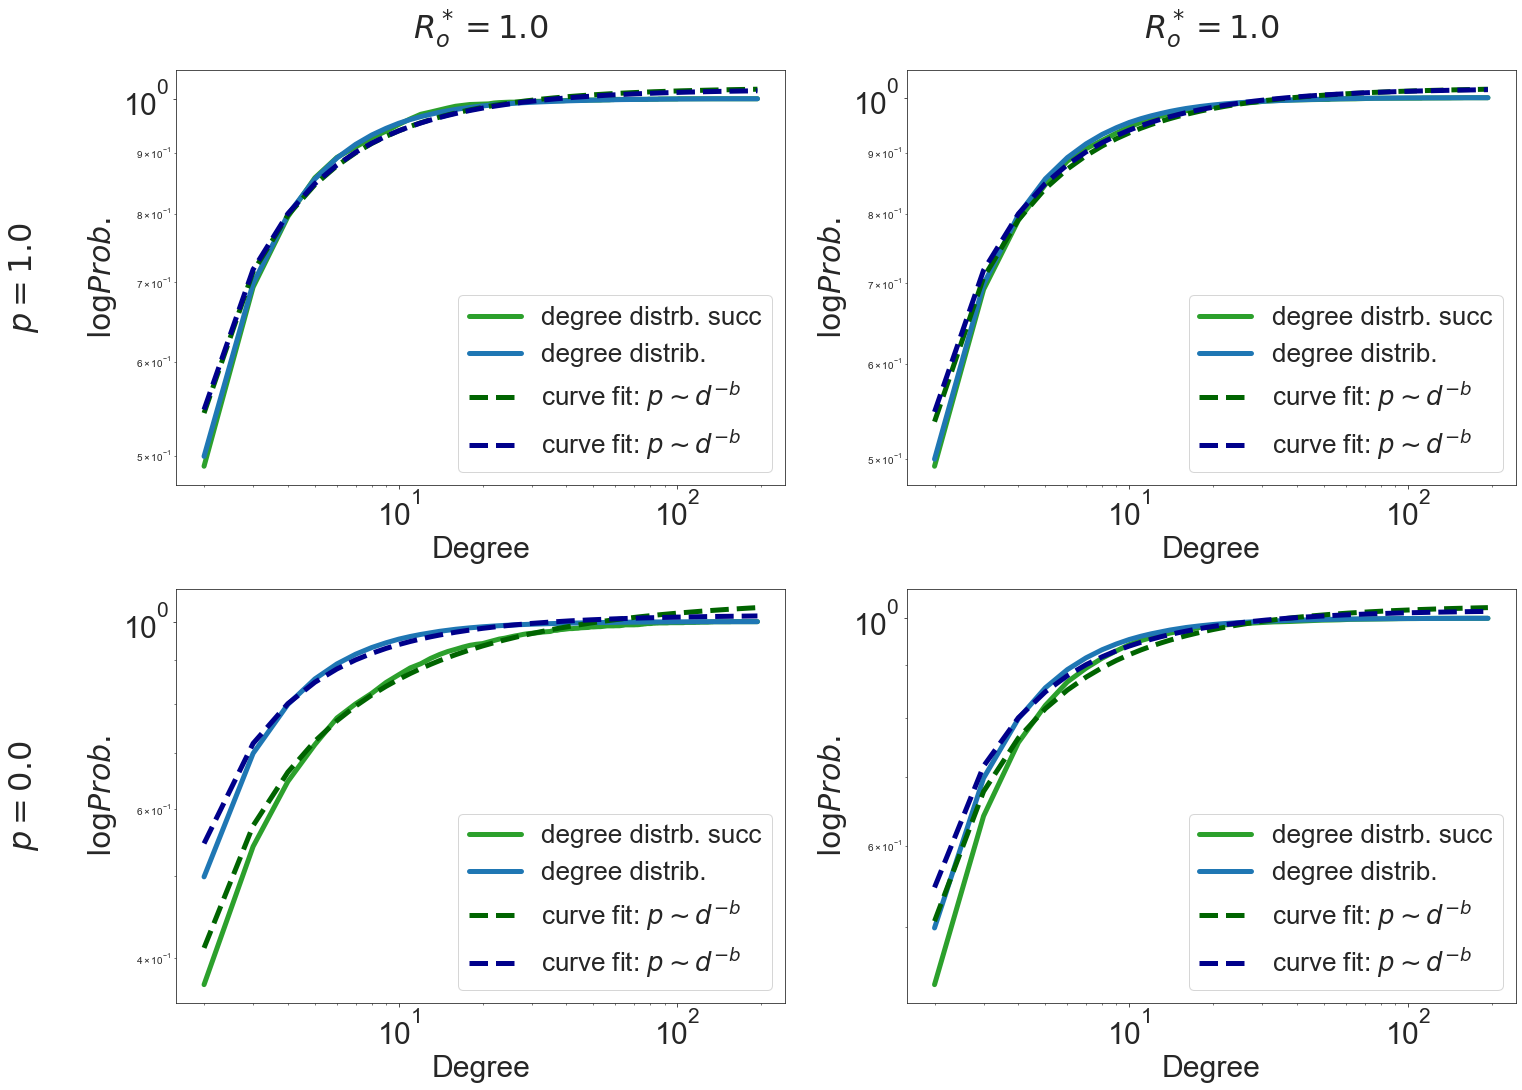

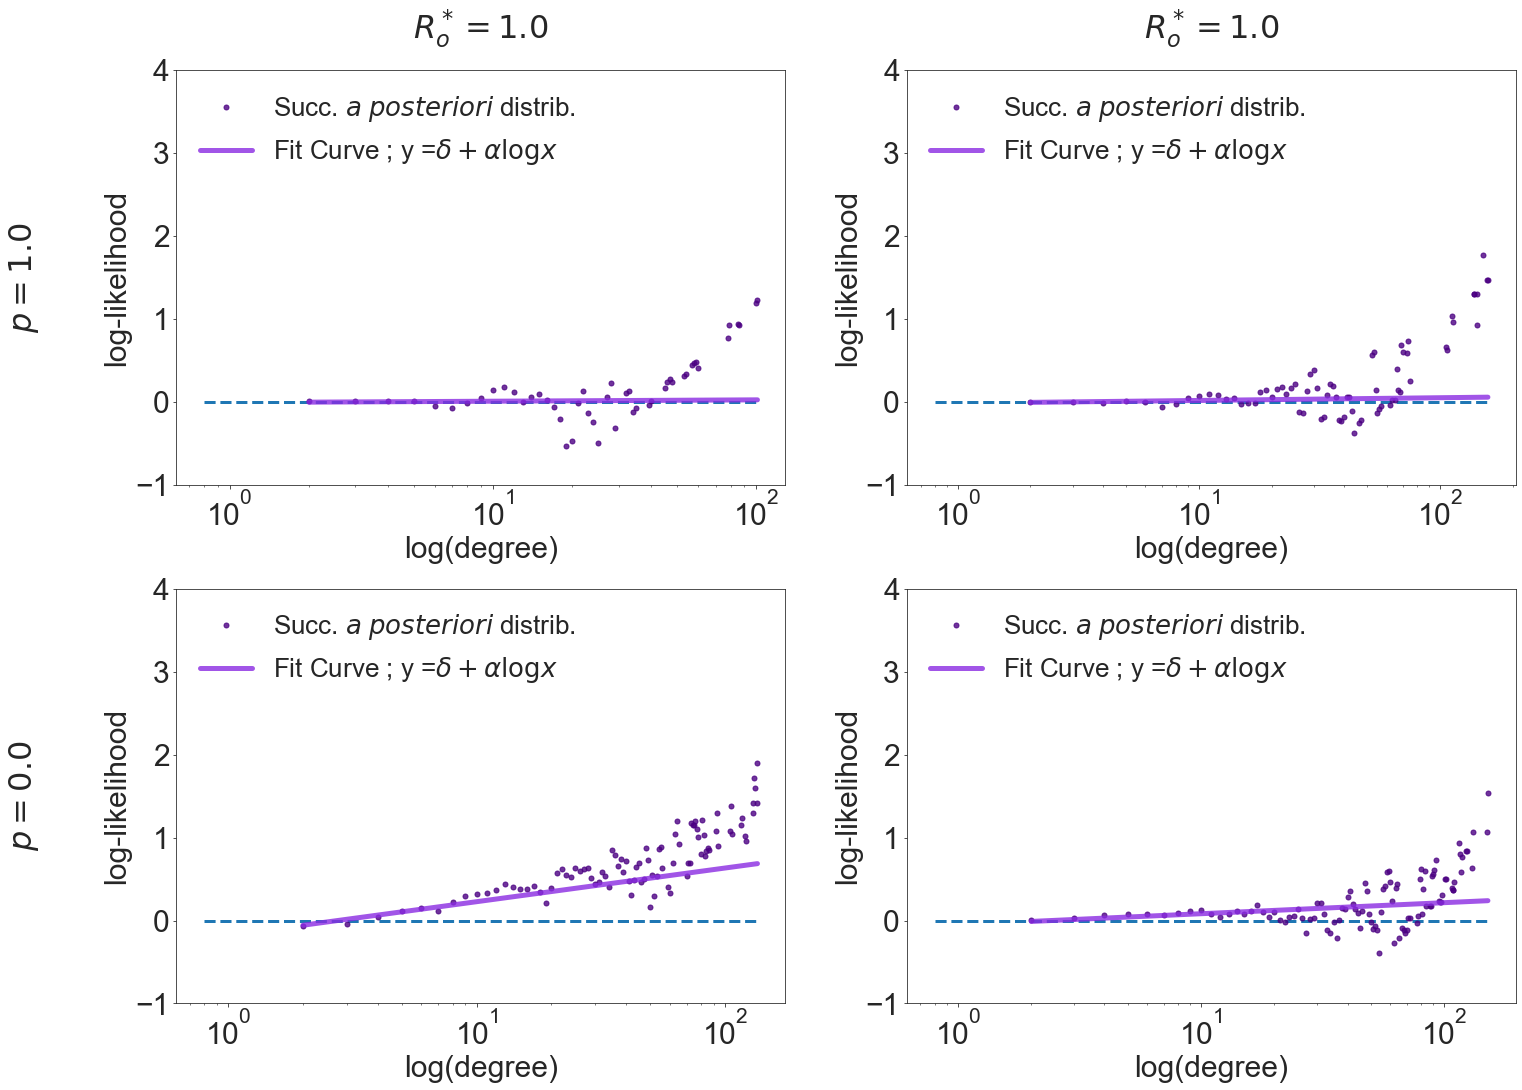

In [32]:
ps = np.array([1.0, 0.0])
degrees = np.array(range(2, max(nodeDegrees)))
graphs_names = np.array(['barabasi-albert','watts-strogatz'])

betas_temp = np.array([1.2, 4.5])*1/6
R0ss_temp = np.sqrt(1-4*((sigma*(gamma-betas_temp))/(sigma+gamma)**2)) 
print(R0ss_temp)

fig1, ax1 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})
fig2, ax2 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})
fig3, ax3 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})
fig4, ax4 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})

#plot histogram of network degree distribution
data = np.histogram(nodeDegrees, bins=range(2, max(nodeDegrees)+1),density = True)   

max_degree_fit = 50

i_p = 0
for p in ps:
    i_b = 0
    ##Run over graphs
    for G, G_name in zip(graphs, graphs_names):
        ##Run over R0s
        for beta in betas_temp:
            
            if(i_b == 0):
                ax1[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax1[i_p, i_b].transAxes)
                ax2[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax2[i_p, i_b].transAxes)
                ax3[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax3[i_p, i_b].transAxes)
                ax4[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax4[i_p, i_b].transAxes)
            if(i_p == 0):
                ax1[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax1[i_p, i_b].transAxes)
                ax2[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax2[i_p, i_b].transAxes)
                ax3[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax3[i_p, i_b].transAxes)
                ax4[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax4[i_p, i_b].transAxes)

            succ_nodes_file = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma,sigma, N, p)+G_name+'.txt', dtype = 'i')
            succ_nodes1 = succ_nodes_file[:,0][succ_nodes_file[:,1]==1]
            #succ_nodes2 = np.loadtxt('../Text_files/Stochastic/Networks/barabasi-albert/degree_no_epi_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma,sigma, N, p)+G_name+'.txt', dtype = 'i')
            print(r'epi_nodes $(p=%.1f ; R_0=%.1f)$ :'%(p, beta/gamma), len(succ_nodes1))
            ######### Plot histograms #########
            #plt.title(G_name + ' Network', fontsize = 16)
            data_succ = ax1[i_p, i_b].hist(np.concatenate((succ_nodes1,[])) , cumulative = True, bins=range(2, max(nodeDegrees)+1), align = 'left', alpha=0.5, color='tab:green', label=('mean degree = %.1f ; Succ.' % np.mean(np.concatenate((succ_nodes1,[])))), density = True)          
            ax1[i_p, i_b].bar(x = data[1][:-1], height=np.cumsum(data[0]), align = 'center',width = 1, alpha=0.5, color='tab:blue', label=('mean degree = %.1f' % meanDegree))
            ax1[i_p, i_b].set_xlim(1, max(nodeDegrees))
            ax1[i_p, i_b].set_xlabel('degree', fontsize = 30)
            ax1[i_p, i_b].set_ylabel('Prob.', fontsize = 30)
            #ax1[i_b, i_p].set_xticks()
            #ax1[i_b, i_p].set_yticks()
            ax1[i_p, i_b].tick_params('both', labelsize=30)
            #ax1[i_p, i_b].set_yscale('log') #Comment to normal scale
            ax1[i_p, i_b].set_xscale('log') #Comment to normal scale
            ax1[i_p, i_b].legend(loc='lower right', fontsize = 26)
            ######### Calculate log_likehood from data #########
            Log_Likelihood_data = np.log10(np.gradient(data_succ[0])/np.gradient(np.cumsum(data[0])))[~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(np.cumsum(data[0]))))]
            degrees_data = degrees[~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(np.cumsum(data[0]))))]
            degrees_data = degrees_data[~np.isinf(Log_Likelihood_data)]
            Log_Likelihood_data = Log_Likelihood_data[~np.isinf(Log_Likelihood_data)]
            ######### Plot log_likelihood histograms #########
            ax2[i_p, i_b].bar(x=degrees_data, height = Log_Likelihood_data, align = 'center',width=1, color ='indigo', alpha = 0.8, label = r'Succ. $\it{a}$ $\it{posteriori}$ distribution')
            #ax.set_xlim(1,60)
            #ax.set_ylim(min(A)*1.2,max(A)*1.2)
            ax2[i_p, i_b].set_xlabel(r'degree', fontsize = 30)
            ax2[i_p, i_b].set_ylabel(r'log-likelihood', fontsize = 30)
            ax2[i_p, i_b].tick_params('both', labelsize=30)
            ax2[i_p, i_b].set_xscale('log')
            ax2[i_p, i_b].legend(fontsize = 26, loc = 2, frameon=False)
            ######### Fit each histogram #########
            A = data_succ[0][data_succ[0]!=0]
            degreesA = degrees[data_succ[0]!=0]
            #poptA, pcovA = curve_fit(my_linear_function, np.log10(degreesA[degreesA<=30]), np.log10(A[degreesA<=30]))
            poptA, pcovA = curve_fit(cumulative_power_law, degreesA[degreesA<=max_degree_fit], A[degreesA<=max_degree_fit], p0 = (-3, 400.0))
            #B = data[0][data[0]!=0]
            B = np.cumsum(data[0])
            #degreesB = degrees[data[0]!=0]
            degreesB = degrees
            #poptB, pcovB = curve_fit(my_linear_function, np.log10(degreesB[degreesB<=30]), np.log10(B[degreesB<=30]))
            poptB, pcovB = curve_fit(cumulative_power_law, degreesB[degreesB<=max_degree_fit], B[degreesB<=max_degree_fit], p0 = (-3, 400.0))
            network_params = poptB
            #Log_Likelihood = (np.log10(np.gradient(10**my_linear_function(np.log10(degrees), *poptA)))-np.log10(np.gradient(10**my_linear_function(np.log10(degrees), *poptB))))
            Log_Likelihood = (np.log10(np.gradient(cumulative_power_law(degrees, *poptA)))-np.log10(np.gradient(cumulative_power_law(degrees, *poptB))))
            ######### Plot fits of both histograms #########
            ax3[i_p, i_b].plot(degreesA, A, linewidth = 5, color = 'tab:green', label = 'degree distrb. succ')
            ax3[i_p, i_b].plot(degreesB, B, linewidth = 5, color = 'tab:blue', label = 'degree distrib.')
            #ax3[i_p, i_b].plot(degrees, 10**(my_linear_function(np.log10(degrees), *poptA)), '--', linewidth = 5, color = 'darkgreen', label = r'curve fit: $p\sim d^{-b}$')
            ax3[i_p, i_b].plot(degrees, (cumulative_power_law(degrees, *poptA)), '--', linewidth = 5, color = 'darkgreen', label = r'curve fit: $p\sim d^{-b}$')
            #ax3[i_p, i_b].plot(degrees, 10**(my_linear_function(np.log10(degrees), *poptB)), '--', linewidth = 5, color = 'darkblue', label = r'curve fit: $p\sim d^{-b}$')
            ax3[i_p, i_b].plot(degrees, (cumulative_power_law(degrees, *poptB)), '--', linewidth = 5, color = 'darkblue', label = r'curve fit: $p\sim d^{-b}$')
            ax3[i_p, i_b].set_yscale('log')
            ax3[i_p, i_b].set_xscale('log')
            ax3[i_p, i_b].set_xlabel('Degree', fontsize = 30)
            ax3[i_p, i_b].set_ylabel(r'$\log{Prob.}$', fontsize = 30)
            ax3[i_p, i_b].tick_params(labelsize = 30)
            ax3[i_p, i_b].legend(fontsize = 26, loc = 4)
            ######### Fit each log_likelihood and save the parameters #########
            if(p == 0.0):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood)
            if(p == 1.0):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood)
            ######### Plot fits of log_likelihood together with data #########           
            degrees_array = np.linspace(min(degrees), max(degrees_data), 200)
            ax4[i_p, i_b].plot(degrees_data, Log_Likelihood_data,'.',  color ='indigo', alpha = 0.8, ms = 10, label = r'Succ. $\it{a}$ $\it{posteriori}$ distrib.')
            ax4[i_p, i_b].plot(degrees_array, my_linear_function(np.log10(degrees_array), *popt),'-', color ='blueviolet', linewidth = 5, alpha = 0.8, label = r'Fit Curve ; y =$ \delta + \alpha\log{x}$')
            ax4[i_p, i_b].hlines(0, 0.8, max(degrees_data), linestyle = 'dashed', linewidth = 3)
            #ax4[i_p, i_b].set_ylim(abs(min(Log_Likelihood_data))*-2,max(Log_Likelihood_data)*1.3)
            ax4[i_p, i_b].set_xscale('log')
            ax4[i_p, i_b].set_xlabel(r'log(degree)', fontsize = 30)
            ax4[i_p, i_b].set_ylabel(r'log-likelihood', fontsize = 30)
            ax4[i_p, i_b].tick_params('both', labelsize=30)
            ax4[i_p, i_b].set_ylim(-1, 4)
            if(p != 1.0):
                ax4[i_p, i_b].legend(fontsize = 26, frameon=False, loc = 2)
            if(p == 1.0):
                ax4[i_p, i_b].legend(fontsize = 26, frameon=False, loc = 2)
                
            i_b+=1
        i_p+=1
print(network_params)
#fig1.savefig('../Figures/Stochastic/Networks/'+G_name+'/hist_degree_succ_N%.0f_'%(N)+G_name+'.pdf', transparent = True)
#fig2.savefig('../Figures/Stochastic/Networks/'+G_name+'/hist_likelihood_succ_N%.0f_'%(N)+G_name+'.pdf', transparent = True)
#fig3.savefig('../Figures/Stochastic/Networks/'+G_name+'/fits_hist_degree_succ_N%.0f_'%(N)+G_name+'.pdf', transparent = True)
#fig4.savefig('../Figures/Stochastic/Networks/'+G_name+'/fits_likelihood_succ_N%.0f_'%(N)+G_name+'.pdf', transparent = True)


[1.00006664 1.0011656 ]
epi_nodes $(p=1.0 ; R_0=1.2)$ : 2425
epi_nodes $(p=1.0 ; R_0=4.5)$ : 7543
epi_nodes $(p=0.0 ; R_0=1.2)$ : 2885
epi_nodes $(p=0.0 ; R_0=4.5)$ : 13019
[-2.18761888 28.44565495]


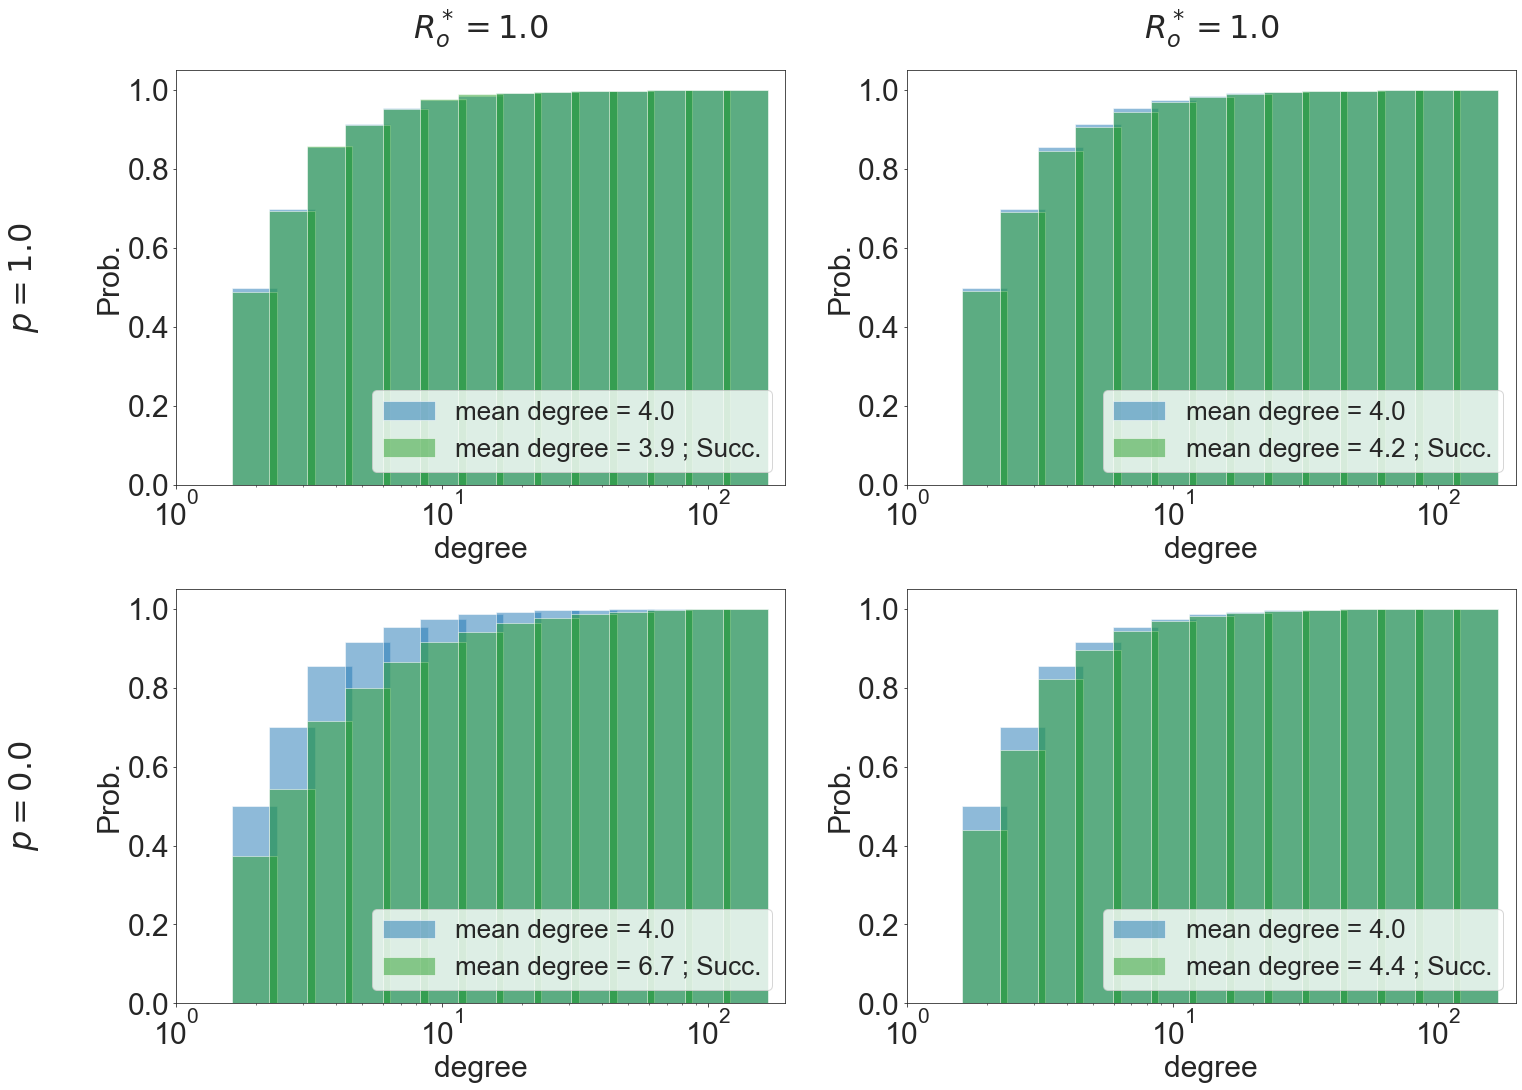

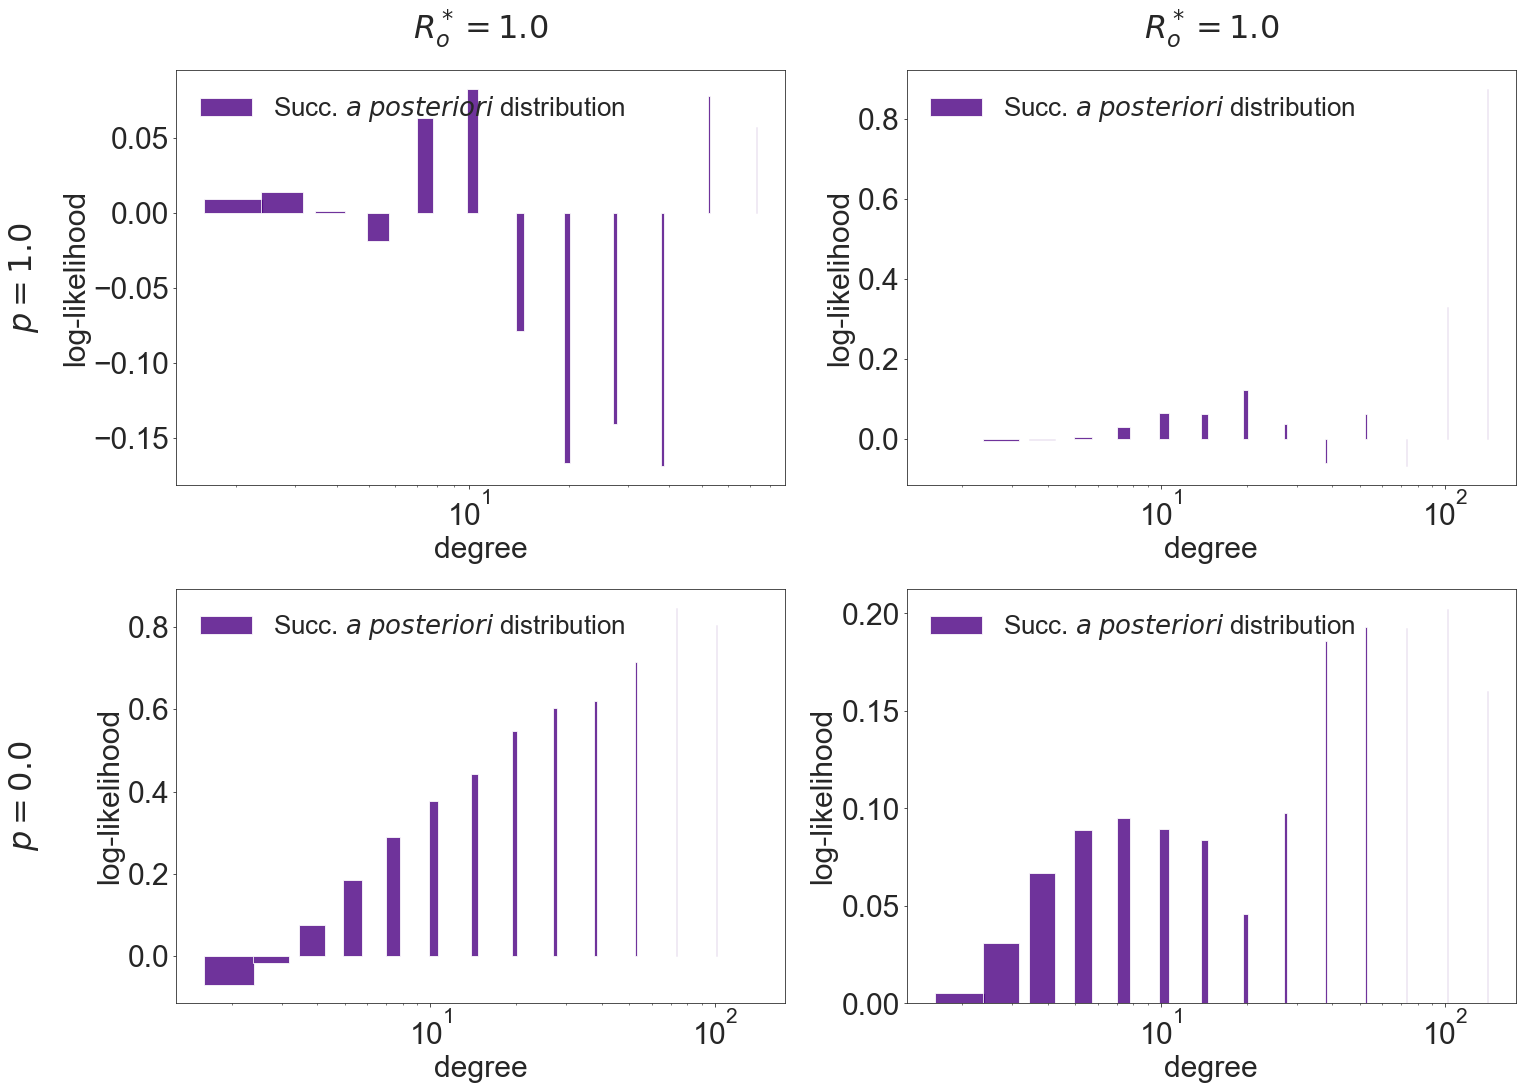

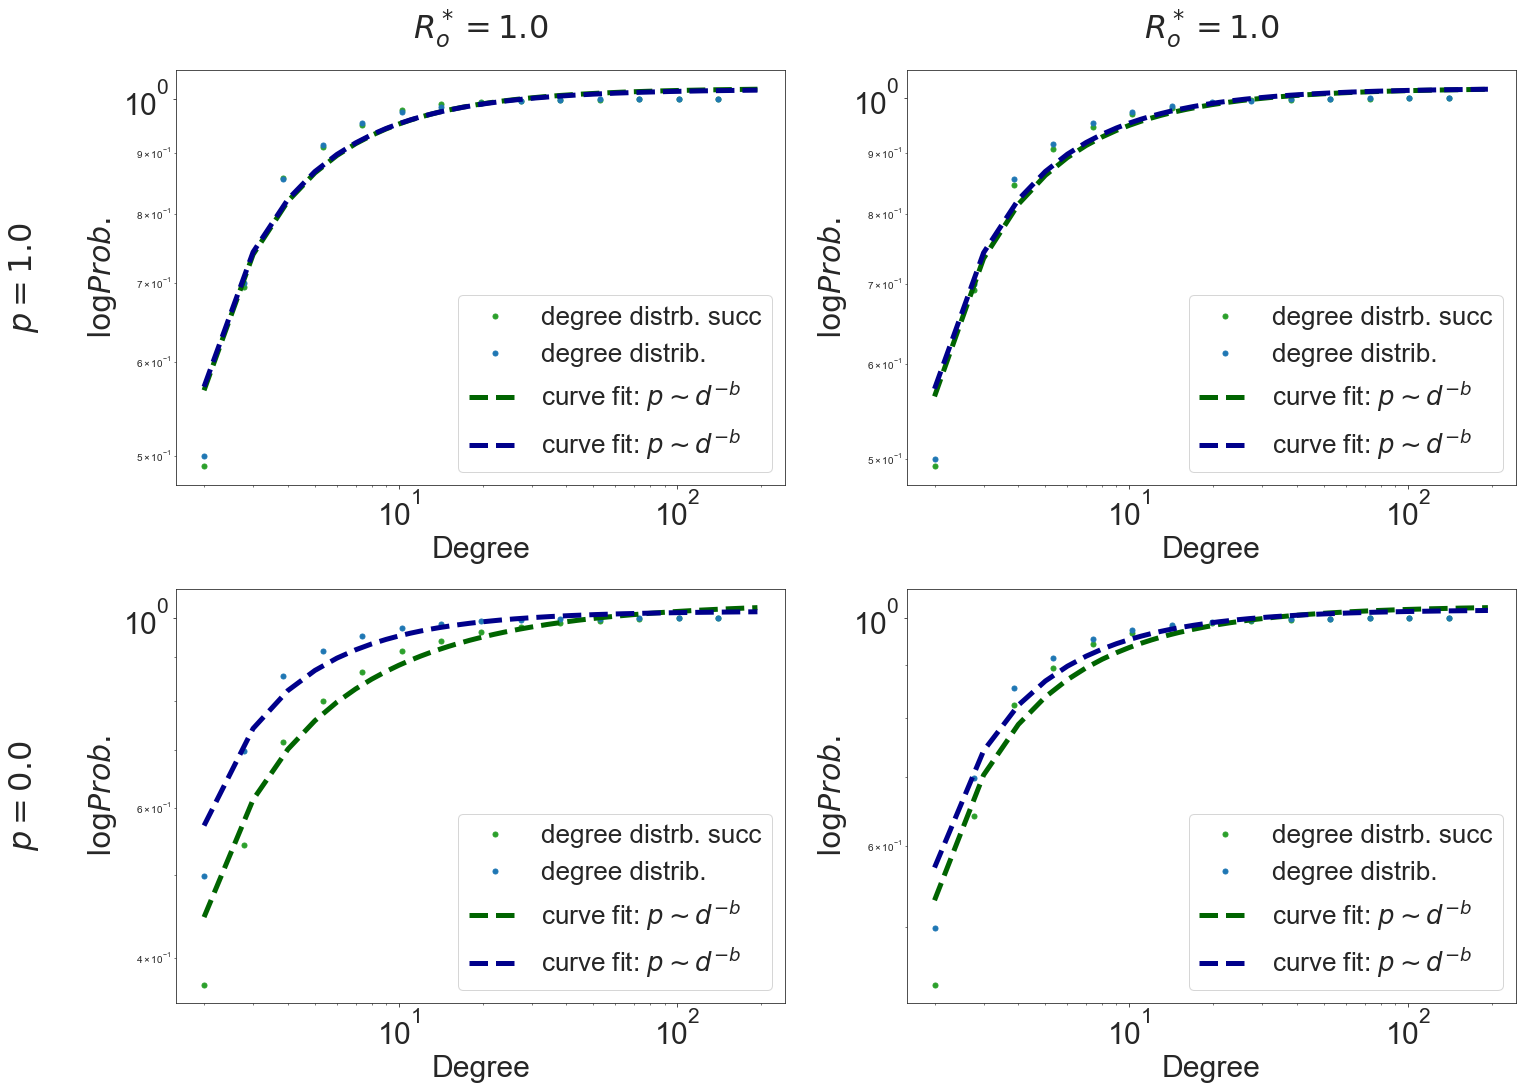

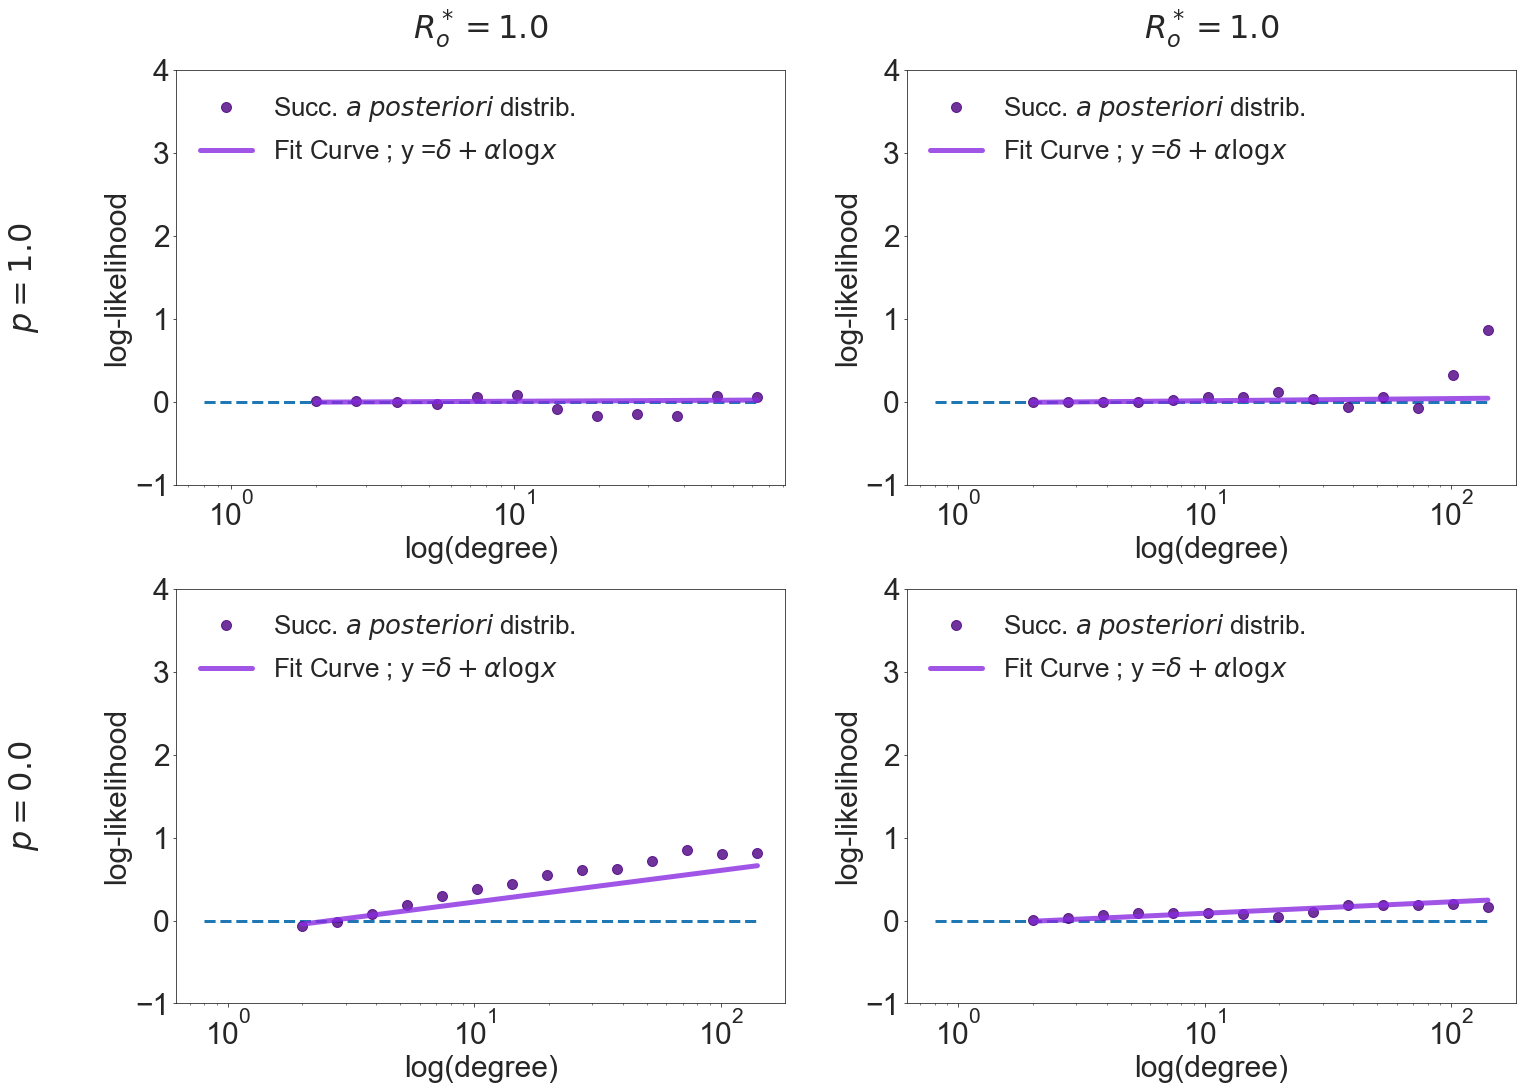

In [34]:
ps = np.array([1.0, 0.0])
degrees = np.array(range(2, max(nodeDegrees)))
graphs_names = np.array(['barabasi-albert','watts-strogatz'])

betas_temp = np.array([1.2, 4.5])*1/6
R0ss_temp = np.sqrt(1-4*((sigma*(gamma-betas_temp))/(sigma+gamma)**2)) 
print(R0ss_temp)

fig1, ax1 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})
fig2, ax2 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})
fig3, ax3 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})
fig4, ax4 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})

#plot histogram of network degree distribution
#data = np.histogram(, bins=np.logspace(np.log10(2), np.log10(max(nodeDegrees)), 50),density = True) 

max_degree_fit = max(degrees)

i_p = 0
for p in ps:
    i_b = 0
    ##Run over graphs
    for G, G_name in zip(graphs, graphs_names):
        ##Run over R0s
        for beta in betas_temp:
            
            if(i_b == 0):
                ax1[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax1[i_p, i_b].transAxes)
                ax2[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax2[i_p, i_b].transAxes)
                ax3[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax3[i_p, i_b].transAxes)
                ax4[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax4[i_p, i_b].transAxes)
            if(i_p == 0):
                ax1[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax1[i_p, i_b].transAxes)
                ax2[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax2[i_p, i_b].transAxes)
                ax3[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax3[i_p, i_b].transAxes)
                ax4[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax4[i_p, i_b].transAxes)

            succ_nodes_file = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma,sigma, N, p)+G_name+'.txt', dtype = 'i')
            succ_nodes1 = succ_nodes_file[:,0][succ_nodes_file[:,1]==1]
            #succ_nodes2 = np.loadtxt('../Text_files/Stochastic/Networks/barabasi-albert/degree_no_epi_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma,sigma, N, p)+G_name+'.txt', dtype = 'i')
            print(r'epi_nodes $(p=%.1f ; R_0=%.1f)$ :'%(p, beta/gamma), len(succ_nodes1))
            ######### Plot histograms #########
            #plt.title(G_name + ' Network', fontsize = 16)
            data = ax1[i_p, i_b].hist(nodeDegrees, cumulative = True, bins=np.logspace(np.log10(2), np.log10(max(nodeDegrees)), 15), align = 'left', alpha=0.5, color='tab:blue', label=('mean degree = %.1f' % meanDegree), density = True)
            data_succ = ax1[i_p, i_b].hist(np.concatenate((succ_nodes1, [])) , cumulative = True, bins=np.logspace(np.log10(2), np.log10(max(nodeDegrees)), 15), align = 'left', alpha=0.5, color='tab:green', label=('mean degree = %.1f ; Succ.' % np.mean(np.concatenate((succ_nodes1, [])))), density = True)
            ax1[i_p, i_b].set_xlim(1, max(nodeDegrees))
            ax1[i_p, i_b].set_xlabel('degree', fontsize = 30)
            ax1[i_p, i_b].set_ylabel('Prob.', fontsize = 30)
            #ax1[i_b, i_p].set_xticks()
            #ax1[i_b, i_p].set_yticks()
            ax1[i_p, i_b].tick_params('both', labelsize=30)
            #ax1[i_p, i_b].set_yscale('log') #Comment to normal scale
            ax1[i_p, i_b].set_xscale('log') #Comment to normal scale
            ax1[i_p, i_b].legend(loc='lower right', fontsize = 26)
            ######### Calculate log_likehood from data #########
            Log_Likelihood_data = np.log10(np.gradient(data_succ[0])/np.gradient(data[0]))[~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(data[0])))]
            degrees_data = data[1][:-1][~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(data[0])))]
            degrees_data = degrees_data[~np.isinf(Log_Likelihood_data)]
            Log_Likelihood_data = Log_Likelihood_data[~np.isinf(Log_Likelihood_data)]
            ######### Plot log_likelihood histograms #########
            ax2[i_p, i_b].bar(x=degrees_data, height = Log_Likelihood_data, align = 'center',  color ='indigo', alpha = 0.8, label = r'Succ. $\it{a}$ $\it{posteriori}$ distribution')
            #ax.set_xlim(1,60)
            #ax.set_ylim(min(A)*1.2,max(A)*1.2)
            ax2[i_p, i_b].set_xlabel(r'degree', fontsize = 30)
            ax2[i_p, i_b].set_ylabel(r'log-likelihood', fontsize = 30)
            ax2[i_p, i_b].tick_params('both', labelsize=30)
            ax2[i_p, i_b].set_xscale('log')
            ax2[i_p, i_b].legend(fontsize = 26, loc = 2, frameon=False)
            ######### Fit each histogram #########
            A = data_succ[0]
            degreesA = data_succ[1][:-1]
            #poptA, pcovA = curve_fit(my_linear_function, np.log10(degreesA[degreesA<=30]), np.log10(A[degreesA<=30]))
            poptA, pcovA = curve_fit(cumulative_power_law, degreesA[degreesA<=max_degree_fit], A[degreesA<=max_degree_fit], p0 = (-3, 400.0))
            #B = data[0][data[0]!=0]
            B = data[0]
            #degreesB = degrees[data[0]!=0]
            degreesB = data[1][:-1]
            #poptB, pcovB = curve_fit(my_linear_function, np.log10(degreesB[degreesB<=30]), np.log10(B[degreesB<=30]))
            poptB, pcovB = curve_fit(cumulative_power_law, degreesB[degreesB<=max_degree_fit], B[degreesB<=max_degree_fit], p0 = (-3, 400.0))
            network_params = poptB
            #Log_Likelihood = (np.log10(np.gradient(10**my_linear_function(np.log10(degrees), *poptA)))-np.log10(np.gradient(10**my_linear_function(np.log10(degrees), *poptB))))
            Log_Likelihood = (np.log10(np.gradient(cumulative_power_law(degrees, *poptA)))-np.log10(np.gradient(cumulative_power_law(degrees, *poptB))))
            
            ######### Plot fits of both histograms #########
            ax3[i_p, i_b].plot(degreesA, A, 'o', ms = 5, color = 'tab:green', label = 'degree distrb. succ')
            ax3[i_p, i_b].plot(degreesB, B, 'o', ms = 5, color = 'tab:blue', label = 'degree distrib.')
            #ax3[i_p, i_b].plot(degrees, 10**(my_linear_function(np.log10(degrees), *poptA)), '--', linewidth = 5, color = 'darkgreen', label = r'curve fit: $p\sim d^{-b}$')
            ax3[i_p, i_b].plot(degrees, (cumulative_power_law(degrees, *poptA)), '--', linewidth = 5, color = 'darkgreen', label = r'curve fit: $p\sim d^{-b}$')
            #ax3[i_p, i_b].plot(degrees, 10**(my_linear_function(np.log10(degrees), *poptB)), '--', linewidth = 5, color = 'darkblue', label = r'curve fit: $p\sim d^{-b}$')
            ax3[i_p, i_b].plot(degrees, (cumulative_power_law(degrees, *poptB)), '--', linewidth = 5, color = 'darkblue', label = r'curve fit: $p\sim d^{-b}$')
            ax3[i_p, i_b].set_yscale('log')
            ax3[i_p, i_b].set_xscale('log')
            ax3[i_p, i_b].set_xlabel('Degree', fontsize = 30)
            ax3[i_p, i_b].set_ylabel(r'$\log{Prob.}$', fontsize = 30)
            ax3[i_p, i_b].tick_params(labelsize = 30)
            ax3[i_p, i_b].legend(fontsize = 26, loc = 4)
            ######### Fit each log_likelihood and save the parameters #########
            if(p == 0.0):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood)
            if(p == 1.0):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood)
            ######### Plot fits of log_likelihood together with data #########           
            degrees_array = np.linspace(min(degrees_data), max(degrees_data), 200)
            ax4[i_p, i_b].plot(degrees_data, Log_Likelihood_data,'.',  color ='indigo', alpha = 0.8, ms = 20, label = r'Succ. $\it{a}$ $\it{posteriori}$ distrib.')
            ax4[i_p, i_b].plot(degrees_array, my_linear_function(np.log10(degrees_array), *popt),'-', color ='blueviolet', linewidth = 5, alpha = 0.8, label = r'Fit Curve ; y =$ \delta + \alpha\log{x}$')
            ax4[i_p, i_b].hlines(0, 0.8, max(degrees_data), linestyle = 'dashed', linewidth = 3)
            #ax4[i_p, i_b].set_ylim(abs(min(Log_Likelihood_data))*-2,max(Log_Likelihood_data)*1.3)
            ax4[i_p, i_b].set_xscale('log')
            ax4[i_p, i_b].set_xlabel(r'log(degree)', fontsize = 30)
            ax4[i_p, i_b].set_ylabel(r'log-likelihood', fontsize = 30)
            ax4[i_p, i_b].tick_params('both', labelsize=30)
            ax4[i_p, i_b].set_ylim(-1, 4)
            if(p != 1.0):
                ax4[i_p, i_b].legend(fontsize = 26, frameon=False, loc = 2)
            if(p == 1.0):
                ax4[i_p, i_b].legend(fontsize = 26, frameon=False, loc = 2)
                
            i_b+=1
        i_p+=1
print(network_params)
#fig1.savefig('../Figures/Stochastic/Networks/'+G_name+'/hist_degree_succ_N%.0f_'%(N)+G_name+'.pdf', transparent = True)
#fig2.savefig('../Figures/Stochastic/Networks/'+G_name+'/hist_likelihood_succ_N%.0f_'%(N)+G_name+'.pdf', transparent = True)
#fig3.savefig('../Figures/Stochastic/Networks/'+G_name+'/fits_hist_degree_succ_N%.0f_'%(N)+G_name+'.pdf', transparent = True)
#fig4.savefig('../Figures/Stochastic/Networks/'+G_name+'/fits_likelihood_succ_N%.0f_'%(N)+G_name+'.pdf', transparent = True)




### $\alpha$

p= 1.0
p= 0.0


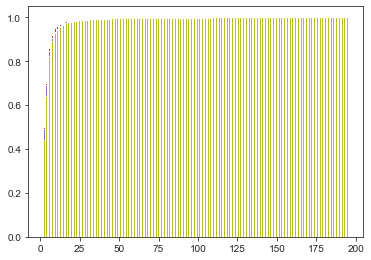

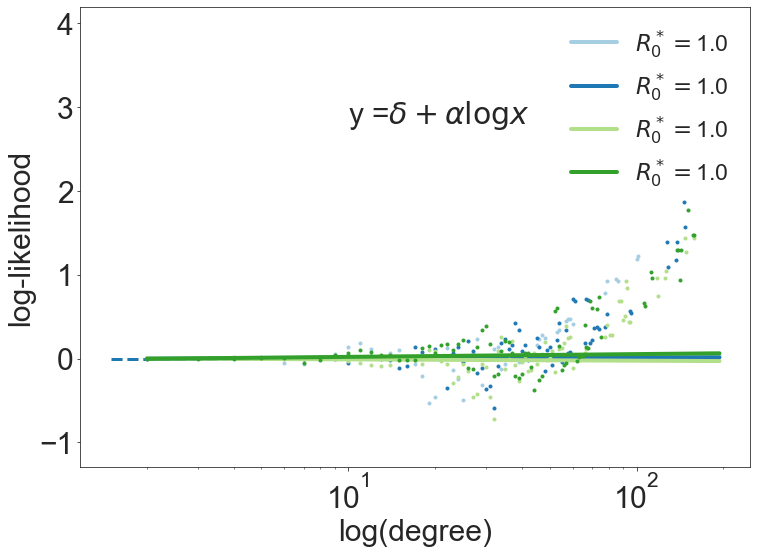

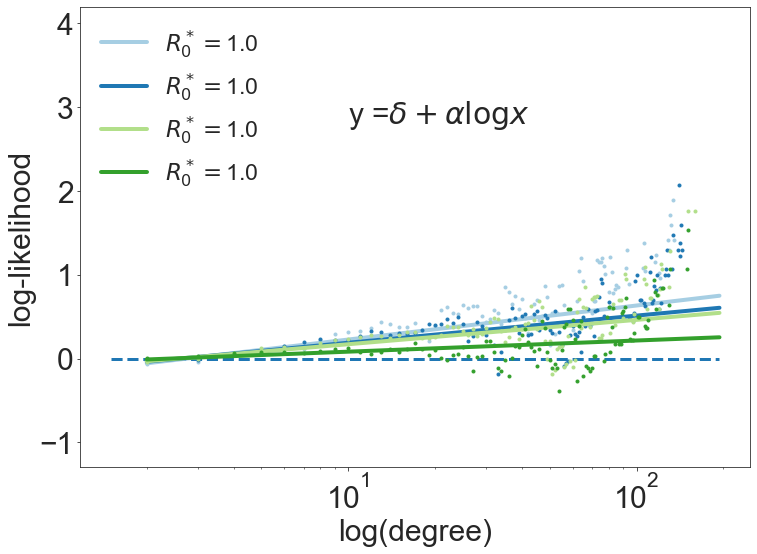

In [35]:
ps = np.array([1.0, 0.0])
R0s = np.array([1.2, 2.0, 3.0, 4.5])
betas = R0s*gamma
R0ss = np.sqrt(1-4*((sigma*(gamma-betas))/(sigma+gamma)**2))
colors_R = plt.cm.Paired(range(5))

fig2, ax2 = plt.subplots(figsize =(6,4), gridspec_kw={'top':0.95, 'bottom': 0.15, 'hspace':0.15})

data = ax2.hist(nodeDegrees, cumulative = True, bins=range(2, max(nodeDegrees)+1), density = True)

like_deg_power10 = np.array([])
like_deg_power_err10 = np.array([])

#like_deg_power05 = np.array([])
#like_deg_power_err05 = np.array([])

#like_deg_power01 = np.array([])
#like_deg_power_err01 = np.array([])

like_deg_power00 = np.array([])
like_deg_power_err00 = np.array([])

surv_prob_p10 = np.array([])
#surv_prob_p05 = np.array([])
#surv_prob_p01 = np.array([])
surv_prob_p00 = np.array([])

max_degree_fit = 50

for p in ps:
    fig, ax = plt.subplots(figsize =(12,8), gridspec_kw={'top':0.95, 'bottom': 0.15, 'hspace':0.15})
    ##Run over graphs
    for G, G_name in zip(graphs, graphs_names):
        ##Run over R0s
        for beta, color, R0s in zip (betas, colors_R, R0ss):
            succ_nodes_file = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma,sigma, N, p)+G_name+'.txt', dtype = 'i')
            succ_nodes1 = succ_nodes_file[:,0][succ_nodes_file[:,1]==1]
            ext_nodes_file = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma,sigma, N, p)+G_name+'.txt', dtype = 'i')
            ext_nodes = succ_nodes_file[:,0][succ_nodes_file[:,2]==1]

            total = len(succ_nodes1)+len(ext_nodes)
            
            ######### Save survival probability
            if(p==1.0):
                surv_prob_p10 = np.append(surv_prob_p10, (len(succ_nodes1))/(total))
            if(p==0.5):
                surv_prob_p05 = np.append(surv_prob_p05, (len(succ_nodes1))/(total))
            if(p==0.1):
                surv_prob_p01 = np.append(surv_prob_p01, (len(succ_nodes1))/(total))
            if(p==0.0):
                surv_prob_p00 = np.append(surv_prob_p00, (len(succ_nodes1))/(total))
                
            ### Calculate histograms
            data_succ = ax2.hist(np.concatenate((succ_nodes1, [])), cumulative = True, bins=range(2, max(nodeDegrees)+1), density = True)
            #########
            #A = data_succ[0][data_succ[0]!=0]
            A = data_succ[0]
            #degreesA = degrees[data_succ[0]!=0]
            degreesA = degrees
            #poptA, pcovA = curve_fit(my_linear_function, np.log10(degreesA[degreesA<=20]), np.log10(A[degreesA<=20]))
            poptA, pcovA = curve_fit(cumulative_power_law, degreesA[degreesA<=max_degree_fit], A[degreesA<=max_degree_fit], p0 = (-3, 400.0))
            #B = data[0][data[0]!=0]
            B = data[0]
            #degreesB = degrees[data[0]!=0]
            degreesB = degrees
            #poptB, pcovB = curve_fit(my_linear_function, np.log10(degreesB[degreesB<=20]), np.log10(B[degreesB<=20]))
            poptB, pcovB = curve_fit(cumulative_power_law, degreesB[degreesB<=max_degree_fit], B[degreesB<=max_degree_fit], p0 = (-3, 400.))
            #Log_Likelihood = (np.log10(np.gradient(10**my_linear_function(np.log10(degrees), *poptA)))-np.log10(np.gradient(10**my_linear_function(np.log10(degrees), *poptB))))
            Log_Likelihood = (np.log10(np.gradient(cumulative_power_law(degrees, *poptA)))-np.log10(np.gradient(cumulative_power_law(degrees, *poptB))))
            #########
            Log_Likelihood_data = np.log10(np.gradient(data_succ[0])/np.gradient(data[0]))[~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(data[0])))]
            degrees_data = degrees[~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(data[0])))]
            degrees_data = degrees_data[~np.isinf(Log_Likelihood_data)]
            Log_Likelihood_data = Log_Likelihood_data[~np.isinf(Log_Likelihood_data)]
            #########
            if(p == 0.0):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood)
                like_deg_power00 = np.append(like_deg_power00,popt[1])
                like_deg_power_err00 = np.append(like_deg_power_err00,pcov[1,1]) 
            if(p == 0.1):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood)
                like_deg_power01 = np.append(like_deg_power01,popt[1])
                like_deg_power_err01 = np.append(like_deg_power_err01,pcov[1,1]) 
            if(p == 0.5):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood)
                like_deg_power05 = np.append(like_deg_power05,popt[1])
                like_deg_power_err05 = np.append(like_deg_power_err05,pcov[1,1]) 
            if(p == 1.0):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees), Log_Likelihood)
                like_deg_power10 = np.append(like_deg_power10,popt[1])
                like_deg_power_err10 = np.append(like_deg_power_err10,pcov[0,0])
            #########
            
            degrees_array = np.linspace(min(degrees), max(degrees), 500)            
            ax.plot(degrees_data, Log_Likelihood_data,'.',color=color)
            ax.plot(degrees_array, my_linear_function(np.log10(degrees_array), *popt),'-',color=color,linewidth = 4, label = r'$R_0^*=$%.1f'%(R0s))
        print('p=', p)
        ax.hlines(0, 1.5, max(degrees), linestyle = 'dashed', linewidth = 3)
        ax.set_ylim(-1.3,4.2)
        ax.set_xscale('log')
        ax.set_xlabel(r'log(degree)', fontsize = 30)
        ax.set_ylabel(r'log-likelihood', fontsize = 30)
        ax.tick_params('both', labelsize=30)
        ax.legend(fontsize = 23, frameon=False)
        ax.text(10, 2.8 , r'y =$ \delta + \alpha\log{x}$', fontsize = 30)
        #fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/loglikelihood_succ_fit_curves_sigma%.1f_N%.0f_p%.1f_.pdf'%(sigma, N, p))
        #fig.close()

### $\alpha$ log binning

[1.00006664 1.00033317 1.00066622 1.0011656 ]
p= 1.0
p= 0.0


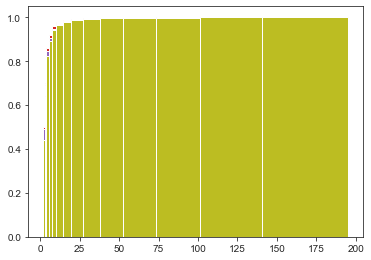

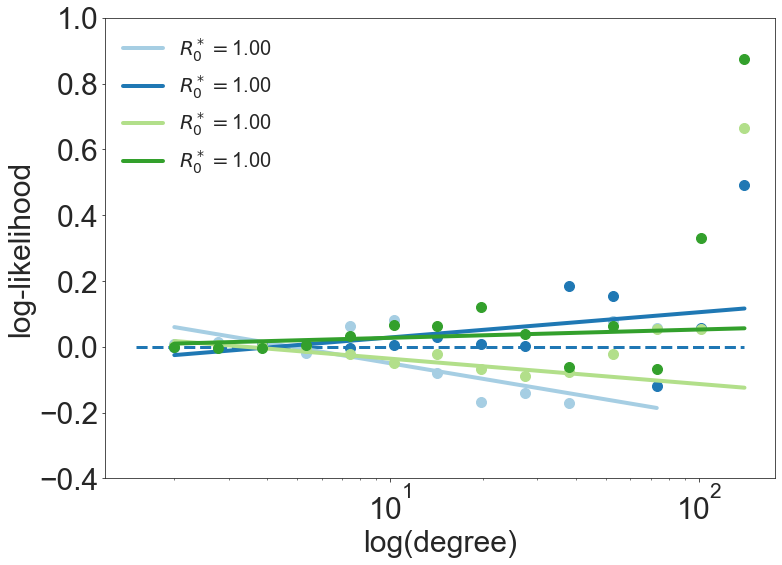

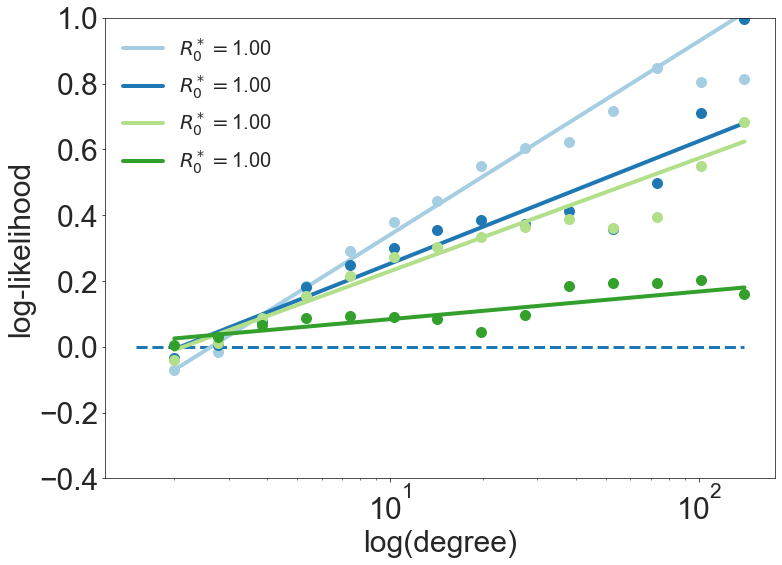

In [51]:
ps = np.array([1.0, 0.0])
R0s = np.array([1.2, 2.0, 3.0, 4.5])
sigma = 1000
betas = R0s*gamma
R0ss = np.sqrt(1-4*((sigma*(gamma-betas))/(sigma+gamma)**2))
print(R0ss)

colors_R = plt.cm.Paired(range(5))
fig2, ax2 = plt.subplots(figsize =(6,4), gridspec_kw={'top':0.95, 'bottom': 0.15, 'hspace':0.15})
data = ax2.hist(nodeDegrees, cumulative= True, bins=np.logspace(np.log10(2), np.log10(max(nodeDegrees)), 15), density = True)

like_deg_power10 = np.array([])
like_deg_power_err10 = np.array([])

#like_deg_power05 = np.array([])
#like_deg_power_err05 = np.array([])

#like_deg_power01 = np.array([])
#like_deg_power_err01 = np.array([])

like_deg_power00 = np.array([])
like_deg_power_err00 = np.array([])

surv_prob_p10 = np.array([])
#surv_prob_p05 = np.array([])
#surv_prob_p01 = np.array([])
surv_prob_p00 = np.array([])

max_degree_fit = 40

for p in ps:
    fig, ax = plt.subplots(figsize =(12,8), gridspec_kw={'top':0.95, 'bottom': 0.15, 'hspace':0.15})
    ##Run over graphs
    for G, G_name in zip(graphs, graphs_names):
        ##Run over R0s
        for beta, color, R0s in zip (betas, colors_R, R0ss):
            succ_nodes_file = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma,sigma, N, p)+G_name+'.txt', dtype = 'i')
            succ_nodes1 = succ_nodes_file[:,0][succ_nodes_file[:,1]==1]
            ext_nodes_file = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%.0f_p%.1f_'%(beta/gamma,sigma, N, p)+G_name+'.txt', dtype = 'i')
            ext_nodes = succ_nodes_file[:,0][succ_nodes_file[:,2]==1]

            total = len(succ_nodes1)+len(ext_nodes)
            
            ######### Save survival probability
            if(p==1.0):
                surv_prob_p10 = np.append(surv_prob_p10, (len(succ_nodes1))/(total))
            if(p==0.5):
                surv_prob_p05 = np.append(surv_prob_p05, (len(succ_nodes1))/(total))
            if(p==0.1):
                surv_prob_p01 = np.append(surv_prob_p01, (len(succ_nodes1))/(total))
            if(p==0.0):
                surv_prob_p00 = np.append(surv_prob_p00, (len(succ_nodes1))/(total))
                
            ### Calculate histograms
            data_succ = ax2.hist(np.concatenate((succ_nodes1,[])), cumulative = True, bins=np.logspace(np.log10(2), np.log10(max(nodeDegrees)), 15), density = True)
            #########
            #A = data_succ[0][data_succ[0]!=0]
            A = data_succ[0]
            #degreesA = degrees[data_succ[0]!=0]
            degreesA = data_succ[1][:-1]
            #poptA, pcovA = curve_fit(my_linear_function, np.log10(degreesA[degreesA<=20]), np.log10(A[degreesA<=20]))
            poptA, pcovA = curve_fit(cumulative_power_law, degreesA[degreesA<=max_degree_fit], A[degreesA<=max_degree_fit], p0 = (-3, 400.0))
            #B = data[0][data[0]!=0]
            B = data[0]
            #degreesB = degrees[data[0]!=0]
            degreesB = data[1][:-1]
            #poptB, pcovB = curve_fit(my_linear_function, np.log10(degreesB[degreesB<=20]), np.log10(B[degreesB<=20]))
            poptB, pcovB = curve_fit(cumulative_power_law, degreesB[degreesB<=max_degree_fit], B[degreesB<=max_degree_fit], p0 = (-3, 400.0))
            #Log_Likelihood = (np.log10(np.gradient(10**my_linear_function(np.log10(degrees), *poptA)))-np.log10(np.gradient(10**my_linear_function(np.log10(degrees), *poptB))))
            Log_Likelihood = np.log10(np.gradient(cumulative_power_law(degrees, *poptA)))-np.log10(np.gradient(cumulative_power_law(degrees, *poptB)))
            #########
            Log_Likelihood_data = np.log10(np.gradient(data_succ[0])/np.gradient(data[0]))[~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(data[0])))]
            degrees_data = data[1][:-1][~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(data[0])))]
            degrees_data = degrees_data[~np.isinf(Log_Likelihood_data)]
            Log_Likelihood_data = Log_Likelihood_data[~np.isinf(Log_Likelihood_data)]
            #########
            if(p == 0.0):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees_data[degrees_data<=max_degree_fit]), Log_Likelihood_data[degrees_data<=max_degree_fit])
                like_deg_power00 = np.append(like_deg_power00,popt[1])
                like_deg_power_err00 = np.append(like_deg_power_err00,pcov[1,1]) 
            if(p == 0.1):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees_data[degrees_data<=max_degree_fit]), Log_Likelihood_data[degrees_data<=max_degree_fit])
                like_deg_power01 = np.append(like_deg_power01,popt[1])
                like_deg_power_err01 = np.append(like_deg_power_err01,pcov[1,1]) 
            if(p == 0.5):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees_data[degrees_data<=max_degree_fit]), Log_Likelihood_data[degrees_data<=max_degree_fit])
                like_deg_power05 = np.append(like_deg_power05,popt[1])
                like_deg_power_err05 = np.append(like_deg_power_err05,pcov[1,1]) 
            if(p == 1.0):
                popt, pcov = curve_fit(my_linear_function, np.log10(degrees_data[degrees_data<=max_degree_fit]), Log_Likelihood_data[degrees_data<=max_degree_fit])
                like_deg_power10 = np.append(like_deg_power10,popt[1])
                like_deg_power_err10 = np.append(like_deg_power_err10,pcov[0,0])
            #########
            
            degrees_array = np.linspace(min(degrees_data), max(degrees_data), 500)            
            ax.plot(degrees_data, Log_Likelihood_data,'.',color=color, ms = 20)
            ax.plot(degrees_array, my_linear_function(np.log10(degrees_array), *popt),'-',color=color,linewidth = 4, label = r'$R_0^*=$%.2f'%(R0s))
        print('p=', p)
        ax.hlines(0, 1.5, max(degrees_data), linestyle = 'dashed', linewidth = 3)
        ax.set_ylim(-.4, 1.)
        ax.set_xscale('log')
        ax.set_xlabel(r'log(degree)', fontsize = 30)
        ax.set_ylabel(r'log-likelihood', fontsize = 30)
        ax.tick_params('both', labelsize=30)
        ax.legend(fontsize = 20, loc=2, frameon=False)
        #ax.text(10, 2.8 , r'y =$ \delta + \alpha\log{x}$', fontsize = 30)
        #fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/loglikelihood_succ_fit_curves_sigma%.1f_N%.0f_p%.1f_.pdf'%(sigma, N, p))
        #fig.close()

### $\alpha$ fitting

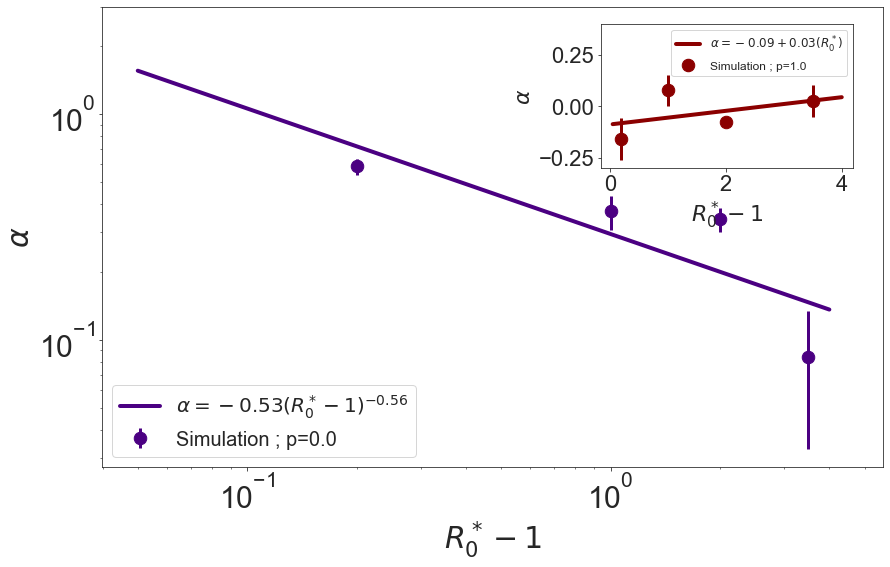

In [38]:
colors_p = ['darkred', 'olive', 'steelblue', 'indigo']

R0s_array = np.linspace(1.05, 5.0, 100)
R0s = np.array([1.2, 2.0, 3.0, 4.5])
popt10, pcov10 = curve_fit(my_linear_function, R0s-1, like_deg_power10)
#popt01, pcov01 = curve_fit(my_linear_function, np.log10(R0ss-1), np.log10(like_deg_power01), p0 = (0.6, 0.2))
#popt05, pcov05 = curve_fit(my_linear_function, np.log10(R0ss-1), np.log10(like_deg_power05), p0 = (0.4, 0.5))
popt00, pcov00 = curve_fit(my_linear_function, np.log10(R0s-1), np.log10(like_deg_power00), p0 = (0.2, 0.1))



fig, ax = plt.subplots(figsize = (14,8), gridspec_kw={'top':0.95, 'bottom': 0.15})
left, bottom, width, height = [0.62, 0.67, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.errorbar(x=R0s-1, y=like_deg_power10, yerr=1.9*np.sqrt(like_deg_power_err10), fmt='.',color = colors_p[0] , linewidth = 3, ms = 25, label = 'Simulation ; p=1.0')
ax2.plot(R0s_array-1, my_linear_function(R0s_array-1, *popt10), color = colors_p[0], linewidth = 4, label = r'$\alpha=%.2f+%.2f(R_0^*)$'%(popt10[0], popt10[1]))
#ax.fill_between(R0s_array, my_linear_function(R0s_array, popt10[0]-np.sqrt(pcov10[0,0]), popt10[1]-np.sqrt(pcov10[1,1])), my_linear_function(R0s_array, popt10[0]+np.sqrt(pcov10[0,0]), popt10[1]+np.sqrt(pcov10[1,1])), linewidth = 0, alpha = 0.3, color = 'red')
ax2.tick_params('both', labelsize = 22)
#ax.set_xlabel(r'$\beta/\gamma$', fontsize = 30)
ax2.set_xlabel(r'$R_0^*-1$', fontsize = 22)
ax2.set_ylabel(r'$\alpha$', fontsize = 22)
ax2.set_ylim(-0.3,0.4)
#ax.set_xlim(0.95,2.5)
ax2.legend(fontsize=12)
#ax.text(1.15, 1.2 , r'$\alpha = a + b (R_0^*-1)^{-c}$', fontsize = 30)

#ax.errorbar(x=R0ss-1, y=like_deg_power05, yerr=1.9*np.sqrt(like_deg_power_err05), fmt='.',color = colors_p[1] , linewidth = 3, ms = 25, label = 'Simulation ; p=0.5')
#ax.plot(R0s_array-1, 10**my_linear_function(np.log10(R0s_array-1), *popt05), color = colors_p[1], linewidth = 4, label = r'$\alpha=%.2f(R_0^*-1)^{%.2f}$'%(popt05[0], popt05[1]))
#ax.fill_between(R0s_array, my_linear_function(R0s_array, popt05[0]-np.sqrt(pcov05[0,0]), popt05[1]-np.sqrt(pcov05[1,1])), my_linear_function(R0s_array, popt05[0]+np.sqrt(pcov05[0,0]), popt05[1]+np.sqrt(pcov05[1,1])), linewidth = 0, alpha = 0.3, color = 'orange')

#ax.errorbar(x=R0ss-1, y=like_deg_power01, yerr=1.9*np.sqrt(like_deg_power_err01), fmt='.',color = colors_p[2] , linewidth = 3, ms = 25, label = 'Simulation ; p=0.1')
#ax.plot(R0s_array-1, 10**my_linear_function(np.log10(R0s_array-1), *popt01), color = colors_p[2], linewidth = 4, label = r'$\alpha=%.2f(R_0^*-1)^{%.2f}$'%(popt01[0], popt01[1]))
#ax.fill_between(R0s_array-1, my_linear_function(R0s_array, popt01[0]-np.sqrt(pcov01[0,0]), popt01[1]-np.sqrt(pcov01[1,1])), my_linear_function(R0s_array, popt01[0]+np.sqrt(pcov01[0,0]), popt01[1]+np.sqrt(pcov01[1,1])), linewidth = 0, alpha = 0.3, color = 'green')

ax.errorbar(x=R0s-1, y=like_deg_power00, yerr=1.9*np.sqrt(like_deg_power_err00), fmt='.',color = colors_p[3] , linewidth = 3, ms = 25, label = 'Simulation ; p=0.0')
ax.plot(R0s_array-1, 10**my_linear_function(np.log10(R0s_array-1), *popt00), color = colors_p[3], linewidth = 4, label = r'$\alpha=%.2f(R_0^*-1)^{%.2f}$'%(popt00[0], popt00[1]))
#ax.fill_between(R0s_array, my_linear_function(R0s_array, popt00[0]-np.sqrt(pcov00[0,0]), popt00[1]-np.sqrt(pcov00[1,1])), my_linear_function(R0s_array, popt00[0]+np.sqrt(pcov00[0,0]), popt00[1]+np.sqrt(pcov00[1,1])), linewidth = 0, alpha = 0.3, color = 'blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params('both', labelsize = 30)
#ax.set_xlabel(r'$\beta/\gamma$', fontsize = 30)
ax.set_xlabel(r'$R_0^*-1$', fontsize = 30)
ax.set_ylabel(r'$\alpha$', fontsize = 30)
ax.set_ylim(-0.1,3)
#ax.set_xlim(0.95,2.5)
ax.legend(fontsize=20, loc = 3)
#ax.text(1.15, 1.2 , r'$\alpha = a + b (R_0^*-1)^{-c}$', fontsize = 30)
ax.hlines(0, 1.05, 4.5, linestyle = 'dashed')
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/alpha_exponent_succ_sigma%.1f_N%.0f_powerLaw.pdf'%(sigma, N))
#print(popt10, popt01, popt00)
#slopes = my_power_law_function(R0ss, *popt01)
#print(like_deg_power01)
#print(slopes)

### $\alpha$ fitting linear

[[ 0.00929831 -0.00360316]
 [-0.00360316  0.00215114]] 
 [[ 0.00276662 -0.00107208]
 [-0.00107208  0.00064005]]
4


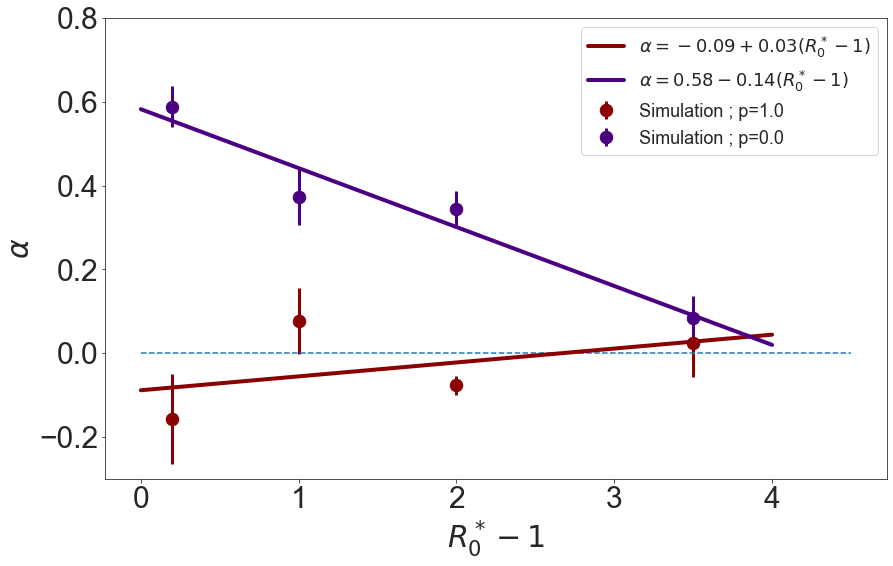

In [39]:
colors_p = ['darkred', 'olive', 'steelblue', 'indigo']

R0s_array = np.linspace(1, 5, 100)

popt10, pcov10 = curve_fit(my_linear_function, R0s-1, like_deg_power10)
#popt01, pcov01 = curve_fit(my_linear_function, R0ss-1, like_deg_power01)
#popt05, pcov05 = curve_fit(my_linear_function, R0ss-1, like_deg_power05)
popt00, pcov00 = curve_fit(my_linear_function, R0s-1, like_deg_power00)

print(pcov10,'\n', pcov00)

fig, ax = plt.subplots(figsize = (14,8), gridspec_kw={'top':0.95, 'bottom': 0.15})
left, bottom, width, height = [0.62, 0.67, 0.25, 0.25]
#ax2 = fig.add_axes([left, bottom, width, height])
print(len(like_deg_power10))
ax.errorbar(x=R0s-1, y=like_deg_power10, yerr=2.0*np.sqrt(like_deg_power_err10), fmt='.',color = colors_p[0] , linewidth = 3, ms = 25, label = 'Simulation ; p=1.0')
ax.plot(R0s_array-1, my_linear_function(R0s_array-1, *popt10), color = colors_p[0], linewidth = 4, label = r'$\alpha=%.2f+%.2f(R_0^*-1)$'%(popt10[0], popt10[1]))
#ax.fill_between(R0s_array, my_linear_function(R0s_array, popt10[0]-np.sqrt(pcov10[0,0]), popt10[1]-np.sqrt(pcov10[1,1])), my_linear_function(R0s_array, popt10[0]+np.sqrt(pcov10[0,0]), popt10[1]+np.sqrt(pcov10[1,1])), linewidth = 0, alpha = 0.3, color = 'red')

#ax2.tick_params('both', labelsize = 22)
#ax.set_xlabel(r'$\beta/\gamma$', fontsize = 30)
#ax2.set_xlabel(r'$R_0^*-1$', fontsize = 22)
#ax2.set_ylabel(r'$\alpha$', fontsize = 22)
#ax2.set_ylim(-0.3,0.4)
#ax.set_xlim(0.95,2.5)
#ax2.legend(fontsize=12)
#ax.text(1.15, 1.2 , r'$\alpha = a + b (R_0^*-1)^{-c}$', fontsize = 30)

#ax.errorbar(x=R0ss-1, y=like_deg_power05, yerr=2.0*np.sqrt(like_deg_power_err05), fmt='.',color = colors_p[1] , linewidth = 3, ms = 25, label = 'Simulation ; p=0.5')
#ax.plot(R0s_array-1, my_linear_function(R0s_array-1, *popt05), color = colors_p[1], linewidth = 4, label = r'$\alpha=%.2f %.2f(R_0^*-1)$'%(popt05[0], popt05[1]))
#ax.fill_between(R0s_array, my_linear_function(R0s_array, popt05[0]-np.sqrt(pcov05[0,0]), popt05[1]-np.sqrt(pcov05[1,1])), my_linear_function(R0s_array, popt05[0]+np.sqrt(pcov05[0,0]), popt05[1]+np.sqrt(pcov05[1,1])), linewidth = 0, alpha = 0.3, color = 'orange')

#ax.errorbar(x=R0ss-1, y=like_deg_power01, yerr=2.0*np.sqrt(like_deg_power_err01), fmt='.',color = colors_p[2] , linewidth = 3, ms = 25, label = 'Simulation ; p=0.1')
#ax.plot(R0s_array-1, my_linear_function(R0s_array-1, *popt01), color = colors_p[2], linewidth = 4, label = r'$\alpha=%.2f %.2f(R_0^*-1)$'%(popt01[0], popt01[1]))
#ax.fill_between(R0s_array-1, my_linear_function(R0s_array, popt01[0]-np.sqrt(pcov01[0,0]), popt01[1]-np.sqrt(pcov01[1,1])), my_linear_function(R0s_array, popt01[0]+np.sqrt(pcov01[0,0]), popt01[1]+np.sqrt(pcov01[1,1])), linewidth = 0, alpha = 0.3, color = 'green')

ax.errorbar(x=R0s-1, y=like_deg_power00, yerr=2.0*np.sqrt(like_deg_power_err00), fmt='.',color = colors_p[3] , linewidth = 3, ms = 25, label = 'Simulation ; p=0.0')
ax.plot(R0s_array-1, my_linear_function(R0s_array-1, *popt00), color = colors_p[3], linewidth = 4, label = r'$\alpha=%.2f %.2f(R_0^*-1)$'%(popt00[0], popt00[1]))
#ax.fill_between(R0s_array, my_linear_function(R0s_array, popt00[0]-np.sqrt(pcov00[0,0]), popt00[1]-np.sqrt(pcov00[1,1])), my_linear_function(R0s_array, popt00[0]+np.sqrt(pcov00[0,0]), popt00[1]+np.sqrt(pcov00[1,1])), linewidth = 0, alpha = 0.3, color = 'blue')

#ax.set_yscale('log')
#ax.set_xscale('log')
ax.tick_params('both', labelsize = 30)
#ax.set_xlabel(r'$\beta/\gamma$', fontsize = 30)
ax.set_xlabel(r'$R_0^*-1$', fontsize = 30)
ax.set_ylabel(r'$\alpha$', fontsize = 30)
ax.set_ylim(-0.3,0.8)
#ax.set_xlim(0.95,2.5)
ax.legend(fontsize=18, loc = 1)
#ax.text(1.15, 1.2 , r'$\alpha = a + b (R_0^*-1)^{-c}$', fontsize = 30)
ax.hlines(0, 0, 4.5, linestyle = 'dashed')
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/alpha_exponent_succ_sigma%.1f_N%.0f_linear.pdf'%(sigma, N))
#print(popt10, popt01, popt00)
#slopes = my_power_law_function(R0ss, *popt01)
#print(like_deg_power01)
#print(slopes)

### Survival/Extinction probability

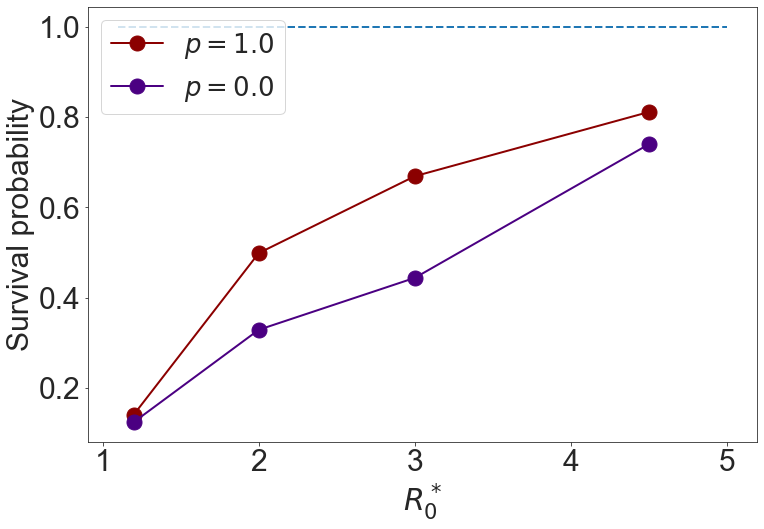

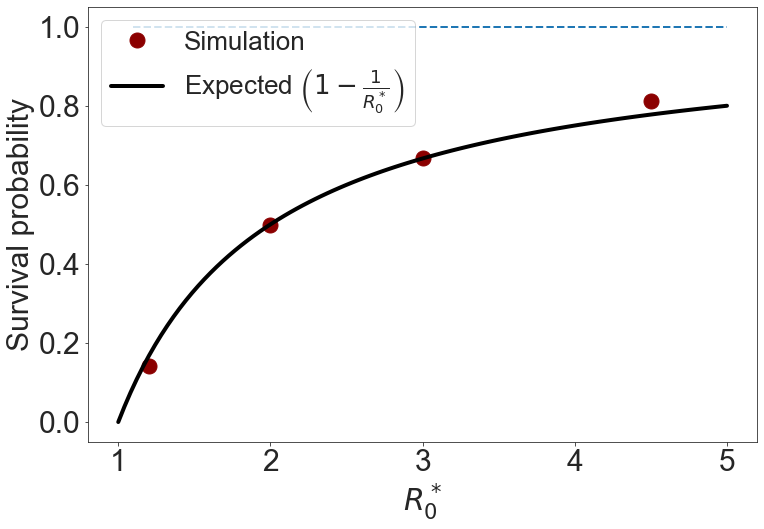

In [40]:
colors_p = plt.cm.tab20b(range(20))
colors_p = ['darkred', 'olive', 'steelblue', 'indigo']
fig, ax = plt.subplots(figsize = (12,8))
T2 = Ts_total*(0.5*(gamma+sigma))
ss = (R0ss-1)
ax.plot(R0s, surv_prob_p10, 'o-', ms=15, color=colors_p[0], linewidth = 2, label = '$p=1.0$')
#ax.plot(R0ss, surv_prob_p05, '.-', ms=15, color=colors_p[1], linewidth = 4, label = '$p=0.5$')
#ax.plot(R0ss, surv_prob_p01, '.-', ms=15, color=colors_p[2], linewidth = 4, label = '$p=0.1$')
ax.plot(R0s, surv_prob_p00, 'o-', ms=15, color=colors_p[3], linewidth = 2, label = '$p=0.0$')
ax.hlines(1,1.1, 5, linewidth = 2, linestyle = 'dashed')
ax.set_xlabel(r'$R_0^*$', fontsize = 30)
ax.set_ylabel(r'Survival probability', fontsize = 30)
ax.tick_params('both', labelsize=30)
#ax.set_ylim(0,1.05)
ax.legend(fontsize = 26, frameon=True)
#ax.set_yscale('log')
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/ext_prob_1.pdf')

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(R0s, surv_prob_p10, 'o', ms=15, color='darkred', linewidth = 4, label = 'Simulation')
#ax.plot(R0ss, 1-( (np.exp(ss*T2)-1) / (((1+(ss))*(np.exp(ss*T2)))-1) ),'.-', ms=15, color= 'k', linewidth = 4, label = r'$1-\frac{1}{R_0^*+1}$')
ax.plot(R0s_array, 1-(1/R0s_array),'-', ms=15, color= 'k', linewidth = 4, label = r'Expected $\left(1-\frac{1}{R_0^*}\right)$')
ax.hlines(1,1.1, 5, linewidth = 2, linestyle = 'dashed')
ax.set_xlabel(r'$R_0^*$', fontsize = 30)
ax.set_ylabel(r'Survival probability', fontsize = 30)
ax.tick_params('both', labelsize=30)
#ax.set_ylim(0,1.05)
ax.legend(fontsize = 26, loc = 2, frameon=True)
#ax.set_yscale('log')
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/ext_prob_2.pdf')

In [141]:
colors_p = plt.cm.terrain([0, 100, 200, 300])
colors_p

array([[0.2       , 0.2       , 0.6       , 1.        ],
       [0.56862745, 0.91372549, 0.51372549, 1.        ],
       [0.56862745, 0.44784314, 0.42196078, 1.        ],
       [1.        , 1.        , 1.        , 1.        ]])

### Establishment SIR vs. SEIR

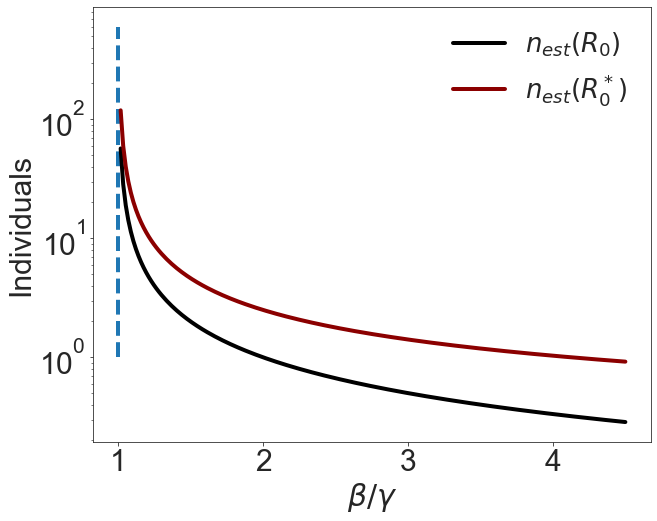

In [41]:
sigma = 1/4
gamma = 1/6
beta1 = np.linspace(1/7, gamma+0.0001, 40)
beta2 = np.linspace(gamma, 4.5*gamma, 200)

fig, ax = plt.subplots(figsize = (10,8))
#ax.plot(beta1, est0(beta1), '.-', ms = 15, color='darkblue', linewidth = 4)
ax.plot(beta2/gamma, est_function_0(beta2, gamma), '-', ms = 15, color='black', label = '$n_{est}(R_0)$', linewidth = 4)

#ax.plot(beta1, est(beta1), '.-', ms=15, color='darkgreen', linewidth = 4)
ax.plot(beta2/gamma, est_function(beta2, gamma), '-', ms = 15, color='darkred', label = '$n_{est}(R_0^*)$', linewidth = 4)
ax.vlines(1,1,600, linestyles='dashed', linewidth = 4)
ax.set_xlabel(r'$\beta/\gamma$', fontsize = 30)
ax.set_ylabel('Individuals', fontsize = 30)
ax.tick_params('both', labelsize=30)
ax.legend(fontsize = 26, frameon=False)
#ax.set_ylim(-200,200)
ax.set_yscale('log')
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/establishment.pdf')

## Establishment (fixation) probability

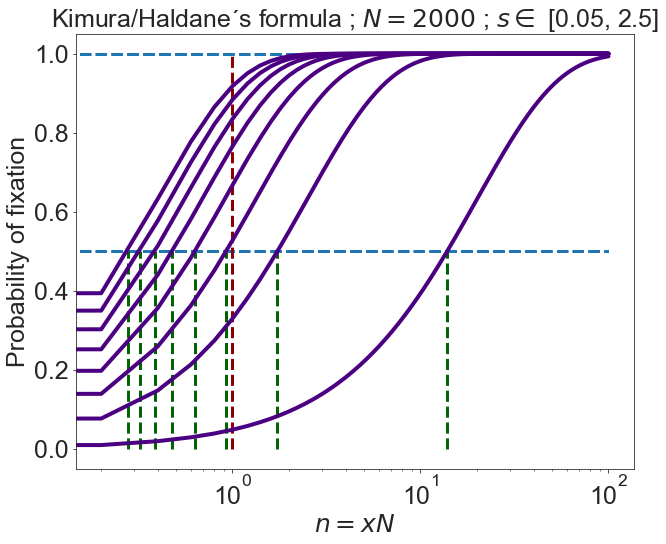

In [42]:
def fixation_prob(x, s, N):
    return (1-np.exp(-N*s*x))/(1-np.exp(-N*s))
N = 2000
x = np.linspace(0,0.05,500)
fig, ax = plt.subplots(figsize = (10,8))
for s in np.linspace(0.05, 2.5, 8):
    ax.set_title(r'Kimura/Haldane´s formula ; $N=%.d$ ; $s\in$ [0.05, 2.5]'%(N) , fontsize = 25)
    ax.plot(x*N, fixation_prob(x, s, N), linewidth = 4, color = 'indigo' , label = 's=%.1f'%(s))
    
    ax.hlines(1,0,100, linewidth = 3, linestyle = 'dashed')
    ax.hlines(.5,0,100, linewidth = 3, linestyle = 'dashed')
    ax.vlines(N*(np.log(2/(1+np.exp(-N*s))))/(N*s),0,0.5, linewidth = 3, linestyle = 'dashed', color = 'darkgreen', label = r'$n_{est}$')
    ax.set_ylabel(r'Probability of fixation', fontsize = 25)
    ax.set_xlabel(r'$n=xN$', fontsize = 25)
    ax.tick_params(labelsize = 25)
    ax.set_xscale('log')
ax.vlines(1, 0, 1, linewidth = 3, linestyle = 'dashed', color = 'darkred')
#ax.legend(fontsize = 25, loc = 4)
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/Prob_Fix.pdf')

### Statistics maximum $n_I$

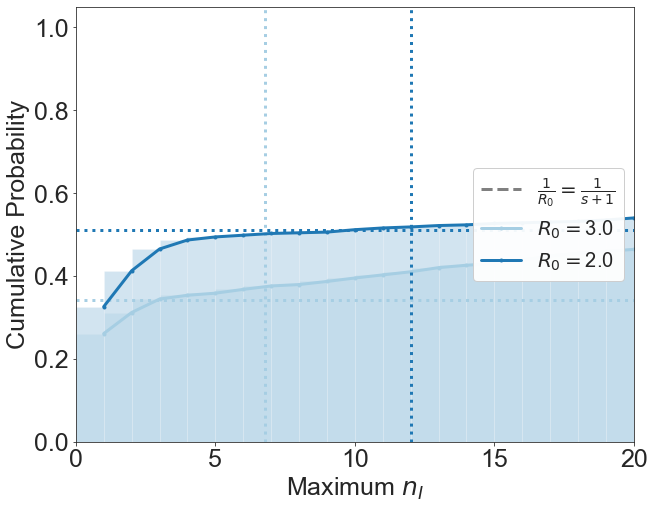

In [43]:
lines_symbols = [Line2D([0], [0], color='grey', linewidth=3, linestyle='--', ms = 8)]
labels_symbols = [r'$\frac{1}{R_0} = \frac{1}{s+1}$']
N = 2000
sigma = 1/4
gamma = 1/6
p = 1.0
fig, ax = plt.subplots(figsize = (10,8))
colors = plt.cm.Paired(range(7))
if(p==0.0):
    R0s = np.array([4.5, 3.0, 2.0, 1.2, 0.8])
if(p==1.0):
    R0s = np.array([3.0, 2.0])    
for i, R0 in enumerate(R0s):
    data = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(R0, sigma, N, p))
    max_values = np.array([max(data[i,:]) for i in range(len(data[:,0]))])
    data_hist = ax.hist(max_values, bins = range(0,int(max(max_values))+1, 1), density =True, cumulative = True, alpha= .2, color = colors[i]);
    if(p==0.0):
        R0 = (R0*(meanDegree2-meanDegree))/(meanDegree*(meanDegree+R0))
    ax.plot(data_hist[1][1:], data_hist[0], '.-', color = colors[i], linewidth = 3, label = r'$R_0=$%.1f'%(R0))
    beta = R0*gamma
    R02 = np.sqrt(1-4*((sigma*gamma-sigma*beta)/(sigma+gamma)**2))
    if(sigma == 1000):
        plt.axvline(((R0-1)*gamma)**(-1), c = colors[i], linewidth = 3, linestyle = 'dashed')
    if(sigma == 1/4):
        plt.axvline(((R02-1)*(gamma+sigma)*0.5)**(-1), c = colors[i], linewidth = 3, linestyle = 'dotted')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    if(sigma == 1000):
        plt.axhline(R0**(-1), c = colors[i], linewidth = 3, linestyle = 'dashed')
    if(sigma == 1/4):
        plt.axhline(R02**(-2), c = colors[i], linewidth = 3, linestyle = 'dotted')
ax.set_xlabel(r'Maximum $n_{{I}}$', fontsize = 25)
ax.set_ylabel(r'Cumulative Probability', fontsize = 25)
ax.set_xlim(0, 20)
#ax.set_ylim(0, 0.5)
ax.tick_params(labelsize = 25)
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , fontsize = 20, loc = 5, framealpha=.95)
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/maximum_ni_1_sigma_%.2f_p%.1f.pdf'%(sigma,p))


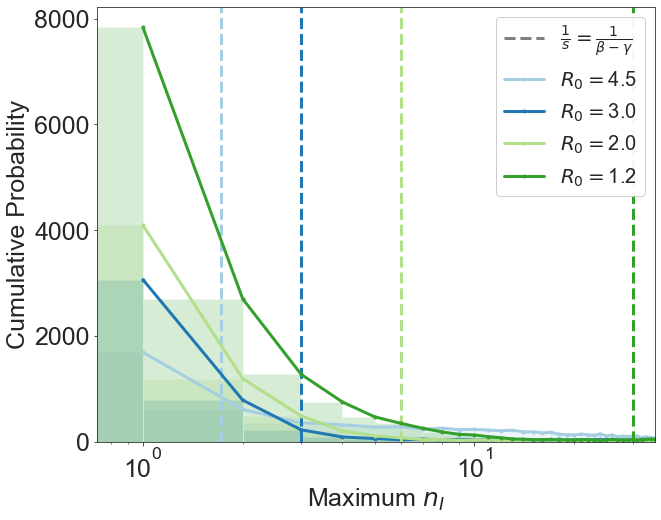

In [44]:
lines_symbols = [Line2D([0], [0], color='grey', linewidth=3, linestyle='--', ms = 8)]
labels_symbols = [r'$\frac{1}{s} = \frac{1}{\beta-\gamma}$']

N = 2000
sigma = 1000
gamma = 1/6
p = 1.0
fig, ax = plt.subplots(figsize = (10,8))
colors = plt.cm.Paired(range(7))
for i, R0 in enumerate([4.5, 3.0, 2.0, 1.2]):
    data = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(R0, sigma, N, p))
    max_values = np.array([max(data[i,:]) for i in range(len(data[:,0]))])
    data_hist = ax.hist(max_values, bins = range(0,int(max(max_values))+1, 1), density =False, cumulative =False, alpha= .2, color = colors[i]);
    ax.plot(data_hist[1][1:], data_hist[0], '.-', color = colors[i], linewidth = 3, label = r'$R_0=$%.1f'%(R0))
    #plt.axhline(R0**(-1), c = colors[i], linewidth = 3)
    plt.axvline(((R0-1)*gamma)**(-1), c = colors[i], linewidth = 3, linestyle = 'dashed')
    #plt.axvline(fixation_size((R0-1)*gamma, N), c = colors[i], linewidth = 3, linestyle = 'dashed')
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0,35)
ax.set_xlabel(r'Maximum $n_{{I}}$', fontsize = 25)
ax.set_ylabel(r'Cumulative Probability', fontsize = 25)
ax.tick_params(labelsize = 25)
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , fontsize = 20, loc = 1, framealpha=.95)
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/maximum_ni_2_p%.1f.pdf'%(p))


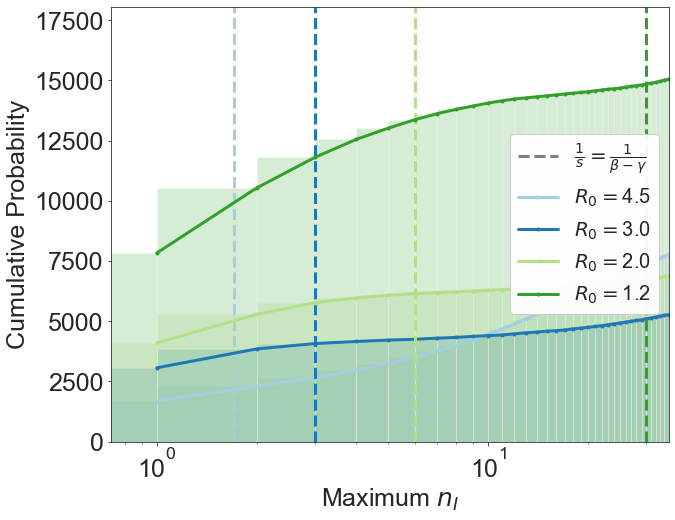

In [45]:
lines_symbols = [Line2D([0], [0], color='grey', linewidth=3, linestyle='--', ms = 8)]
labels_symbols = [r'$\frac{1}{s} = \frac{1}{\beta-\gamma}$']

N = 2000
sigma = 1000
gamma = 1/6
p = 1.0
fig, ax = plt.subplots(figsize = (10,8))
colors = plt.cm.Paired(range(7))
for i, R0 in enumerate([4.5, 3.0, 2.0, 1.2]):
    data = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(R0, sigma, N, p))
    max_values = np.array([max(data[i,:]) for i in range(len(data[:,0]))])
    data_hist = ax.hist(max_values, bins = range(0,int(max(max_values))+1, 1), density =False, cumulative =True, alpha= .2, color = colors[i]);
    ax.plot(data_hist[1][1:], data_hist[0], '.-', color = colors[i], linewidth = 3, label = r'$R_0=$%.1f'%(R0))
    #plt.axhline(R0**(-1), c = colors[i], linewidth = 3)
    plt.axvline(((R0-1)*gamma)**(-1), c = colors[i], linewidth = 3, linestyle = 'dashed')
    #plt.axvline(fixation_size((R0-1)*gamma, N), c = colors[i], linewidth = 3, linestyle = 'dashed')
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0,35)
ax.set_xlabel(r'Maximum $n_{{I}}$', fontsize = 25)
ax.set_ylabel(r'Cumulative Probability', fontsize = 25)
ax.tick_params(labelsize = 25)
handles, labels = ax.get_legend_handles_labels()
ax.legend(np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , fontsize = 20, loc = 5, framealpha=.95)
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/maximum_ni_3_p%.1f.pdf'%(p))



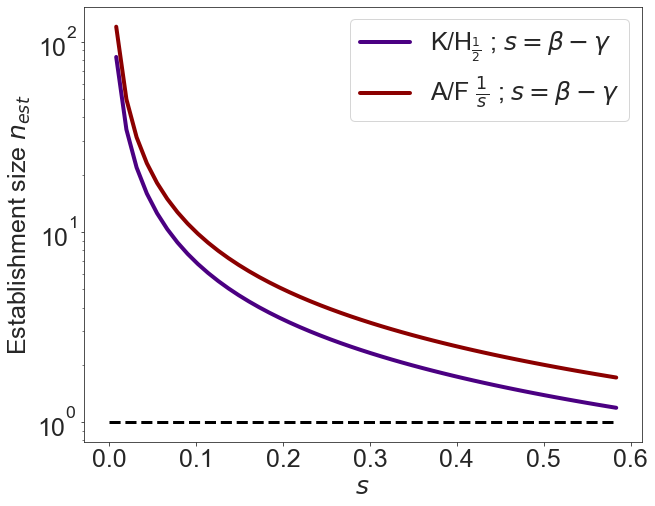

In [547]:
def fixation_size(s, N):
    return (np.log(2/(1+np.exp(-N*s))))/(s)

sigma = 1000
gamma = 1/6
R0 = np.linspace(1.05, 4.5)

#----Selection coefficient using beta-gamma----
s = (R0-1)*gamma
#s = -0.5*(gamma+sigma) + 0.5*np.sqrt((sigma-gamma)**2+4*sigma*beta)

fix, ax = plt.subplots(figsize = (10,8) )
ax.plot(s, fixation_size(s, N), linewidth = 4, color = 'indigo', label = r'K/H$_{\frac{1}{2}}$ ; $s = \beta-\gamma$')
ax.plot(s, est_function_0((s+1)*gamma, gamma), '-', ms = 15, color='darkred', label = r'A/F $\frac{1}{s}$ ; $s = \beta-\gamma$', linewidth = 4)
ax.hlines(1,0,max(s), linestyle = 'dashed', linewidth = 3)
ax.set_yscale('log')
ax.set_xlabel(r'$s$', fontsize = 25)
ax.set_ylabel(r'Establishment size $n_{est}$', fontsize = 25)
ax.tick_params(labelsize = 25)
ax.legend(fontsize=25)

## Establishment as a function of the degree

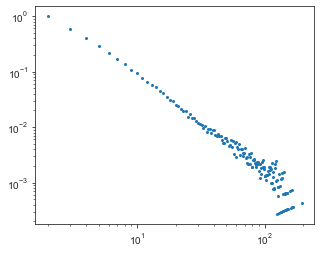

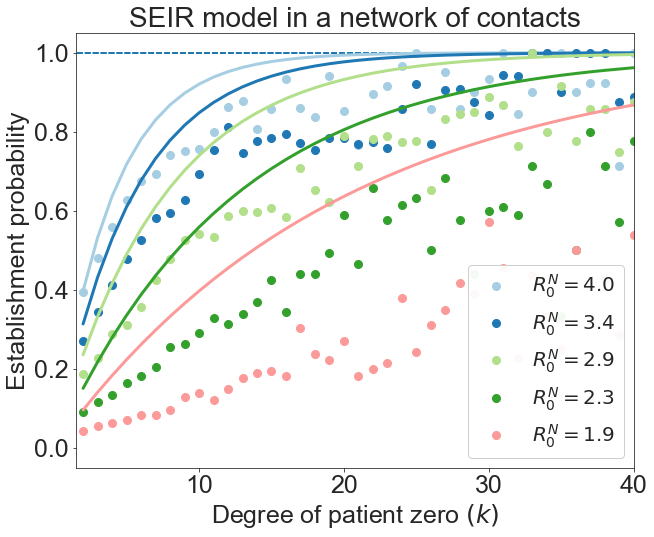

In [48]:
from scipy.stats import expon
from scipy.special import gamma, gammaincc, exp1
def inc_gamma(a, x):
    return exp1(x) if a == 0 else gamma(a)*gammaincc(a, x)

lines_symbols = [Line2D([0], [0], color='grey', linewidth=3, linestyle='--', ms = 8)]
labels_symbols = [r'A/F $1-\frac{1}{R0}$']

N = 2000
sigma = 1/4
gamma = 1/6
p = 0.0

R0s = np.array([4.5, 3.0, 2.0, 1.2])
R0s2 = np.array([4.5, 3.0, 2.0, 1.2, 0.8])
if(p==0.0):
    betas = R0s2*gamma
if(p==1.0):
    betas = R0s*gamma
colors_R = plt.cm.Paired(range(6))
u = np.linspace(0.00005,0.9,100000)

#----Critical occupancy----
T_c = meanDegree/(meanDegree2-meanDegree)
#print('T_c:',T_c, '\n')

#----Load data network of contacts----
data = np.histogram(nodeDegrees, bins=range(2, max(nodeDegrees)+1), density = True)
k = data[1][:-1]
p_k = data[0]

lambda_tau_gamma = gamma
tau_gamma = np.linspace(expon.ppf(0.000001, scale = 1/lambda_tau_gamma), expon.ppf(0.9999, scale = 1/lambda_tau_gamma), 60)
p_tau_gamma = expon.pdf(tau_gamma, scale = 1/lambda_tau_gamma)

#----Extra plots----
if(p==0.0):
    fig_k, ax_k = plt.subplots(figsize = (5,4))
    ax_k.plot(k, k*p_k, 'o', ms = 2)
    ax_k.set_xscale('log')
    ax_k.set_yscale('log')
#----o----

fig, ax = plt.subplots(figsize = (10,8))
if(p==1.0):
    if(sigma==1000):
        ax.set_title('SIR Fully connected model', fontsize = 28)
    if(sigma==1/4):
        ax.set_title('SEIR Fully connected model', fontsize = 28)
if(p==0.0):
    if(sigma==1000):
        ax.set_title('SIR model in a network of contacts', fontsize = 28)
    if(sigma==1/4):
        ax.set_title('SEIR model in a network of contacts', fontsize = 28)

for beta, color, in zip(betas, colors_R):
    #print('beta:', beta)
    beta2 = (((((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*beta))/gamma + 1)*gamma)
    #----Edge Occupancy probability----
    #T = 1-sum(p_k*((4)/((4+((beta*k)/(gamma))))))/(sum(p_k))
    T = 1-((meanDegree)/((meanDegree+((beta2)/(gamma)))))
    #print('T_i:',T)
    #T = ((beta)/(4*gamma))*np.exp(((beta)/(4*gamma)))*inc_gamma(0.0, beta/(4*gamma))
    
    #----Reproductive number----
    if(p==1.0):
        R0 = beta/gamma
    if(p==0.0):
        R0 = T/T_c
    #----Epidemic probability as a function of degree of patient zero----  
    if(p==0.0):
        u_sol = u[[sum(p_k*k*(1+(i-1)*T)**(k-1)) for i in u]>(sum(p_k*k)*u)][-1]
        e_k = 1-(1-T+(T*u_sol))**k
    
    #----Selection coefficient----
    if(p==0.0):
        s = 0.0
    if(p==1.0):
        s = ((beta/gamma)-1)*gamma

    #----Load data with simulation outcomes----
    data_stats = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
    data2 = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
    max_values = np.array([max(data2[i,:]) for i in range(len(data2[:,0]))])
    
    degrees_epi, counts_epi = np.unique(data_stats[:,0][max_values>(1/((R0-1)*gamma))], return_counts=True)
    degrees_ext, counts_ext = np.unique(data_stats[:,0][max_values<(1/((R0-1)*gamma))], return_counts=True)
    max_degree = max(np.concatenate((degrees_epi, degrees_ext)))
    degrees = np.array(range(2,int(max_degree)))
    e_k_data = np.array([])
    for d in degrees:
        n_epi = 0
        n_ext = 0
        #n_no_epi = 0
        n_epi += max(len(counts_epi[degrees_epi==d]), counts_epi[degrees_epi==d])
        n_ext += max(len(counts_ext[degrees_ext==d]), counts_ext[degrees_ext==d])
        #n_no_epi += max(len(counts_no_epi[degrees_no_epi==d]), counts_no_epi[degrees_no_epi==d])
        n_total = n_epi + n_ext
        if(n_total>0):
            e_k_data = np.append(e_k_data, (n_epi)/n_total)
        else:
            temp = np.isin(degrees, d)
            degrees = degrees[~temp]
    
    #----Plot e_k----
    ax.hlines(1,1,max(degrees)*1.1, linestyle = 'dashed')
    if(p==1.0):
        ax.plot(degrees, e_k_data, 'o', color = color, ms = 8, label = r'$R_0=%.1f$'%(R0))
    if(p==0.0):
        ax.plot(degrees, e_k_data, 'o', color = color, ms = 8, label = r'$R_0^N=%.1f$'%(R0))
    if(p==0.0):
        ax.plot(k, e_k, color = color, linewidth = 3)
    if(p==1.0):
        #ax.hlines(fixation_prob(1/N, s, N), 1, max_degree , color = color, linewidth = 3, alpha = 0.2)
        ax.hlines(1-(1/R0), 1, max_degree , color = color, linestyle = 'dashed', linewidth = 3)
    
    ax.set_xlabel(r'Degree of patient zero $(k)$', fontsize = 25)
    ax.set_ylabel(r'Establishment probability', fontsize = 25)
    ax.tick_params(labelsize = 25)
    if(p==0.0):
        ax.set_xlim(1.5, 40)
    if(p==1.0):
        ax.set_xlim(1.5, 40)
    ax.set_ylim(-0.05, 1.05)
    #ax.set_xscale('log')
    #print('\n')

if(p==1.0):
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(np.concatenate((lines_symbols,handles)), np.concatenate((labels_symbols,labels)) , fontsize = 20, loc = 4, framealpha=.95)
if(p==0.0):
    ax.legend(fontsize = 20, loc = 4, framealpha=.95)
#fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/prob_epi_k_p%.1f.pdf'%(p))


[1.00006664 1.0011656 ]
epi_nodes $(p=1.0 ; R_0=1.2)$ : 12
epi_nodes $(p=1.0 ; R_0=4.5)$ : 24
epi_nodes $(p=0.0 ; R_0=1.2)$ : 78
epi_nodes $(p=0.0 ; R_0=4.5)$ : 86
[-2.17128734 30.65007036]


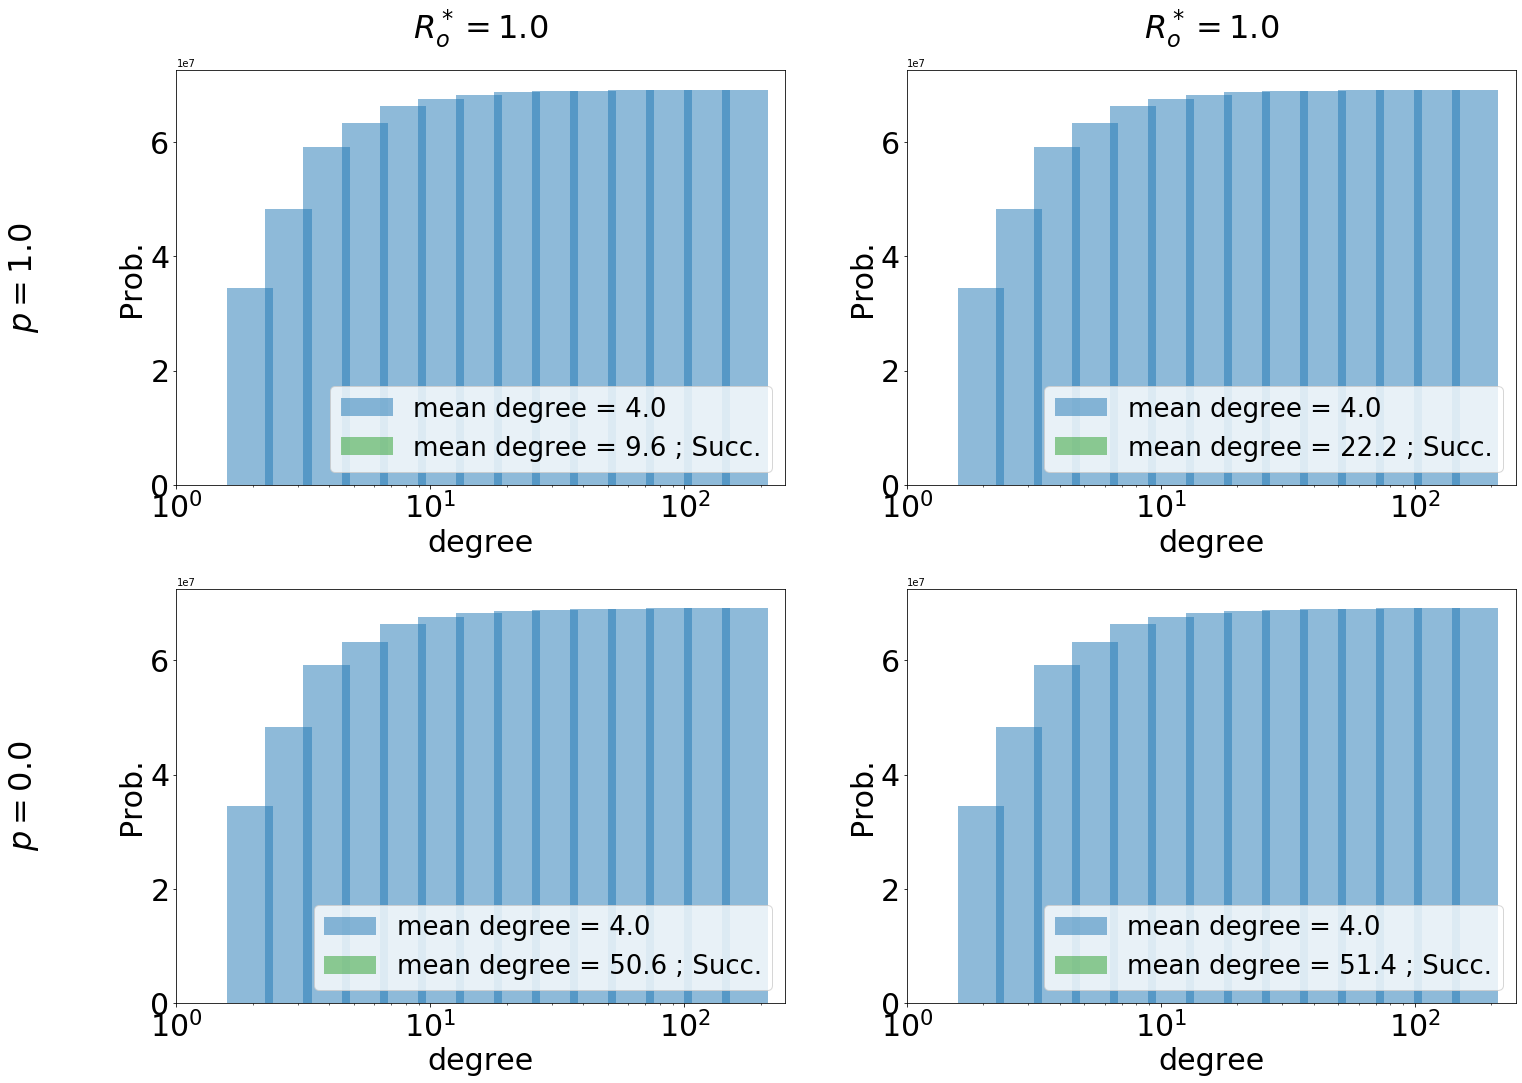

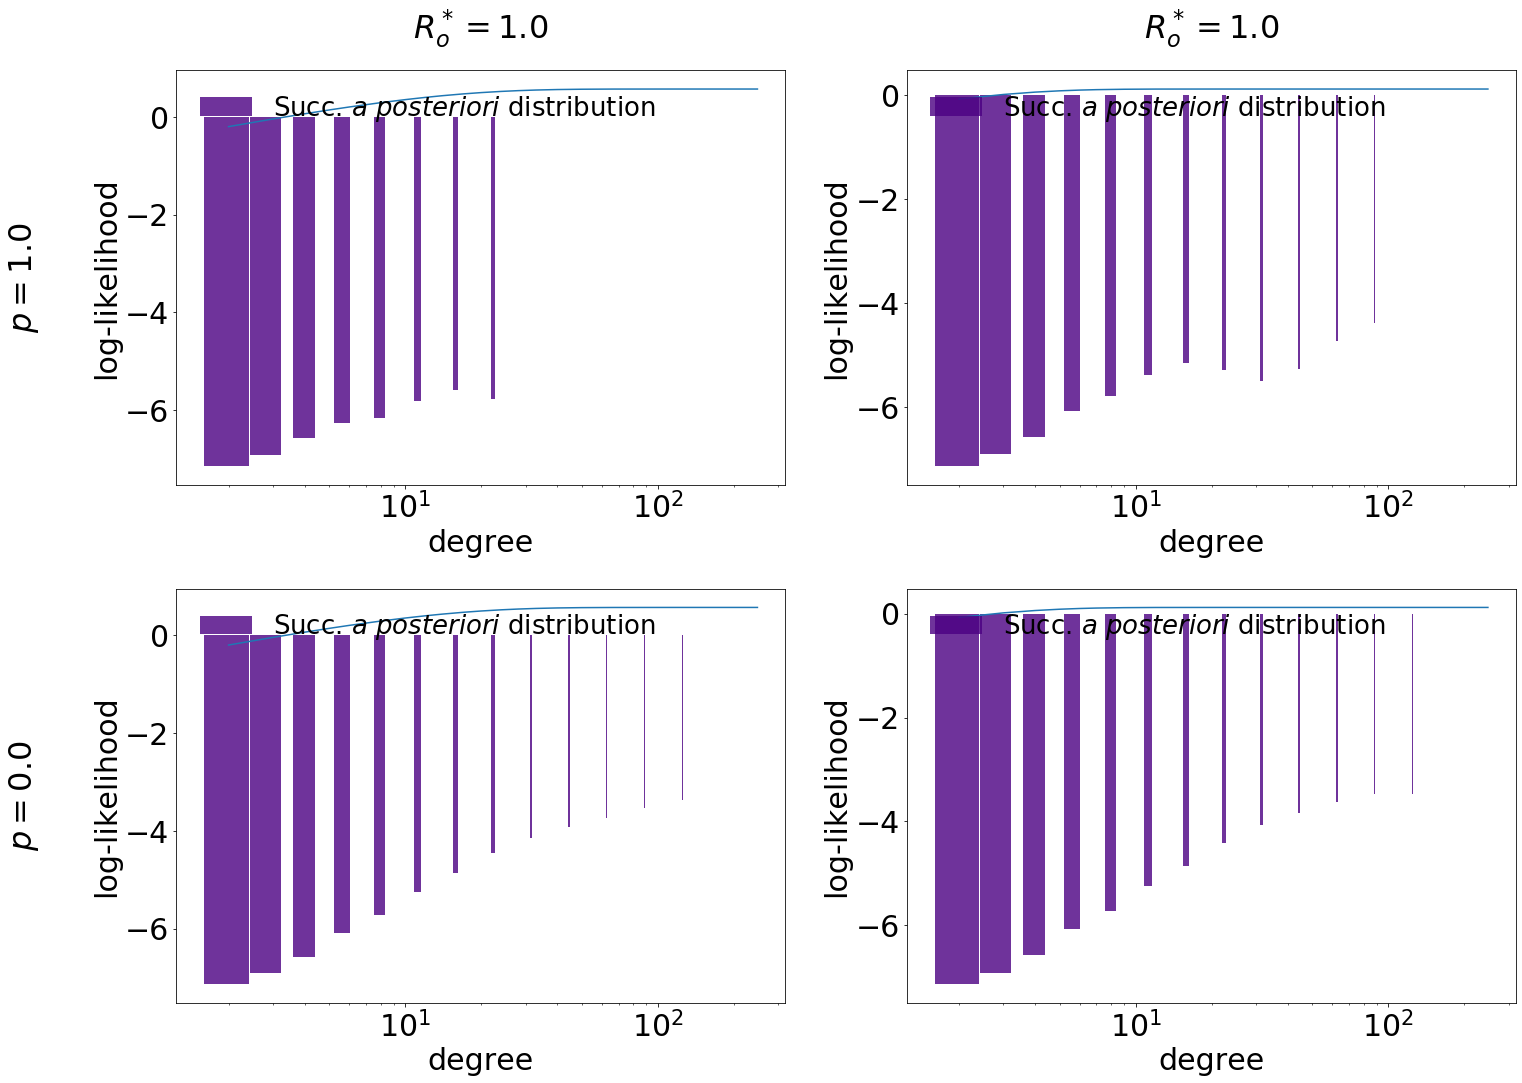

In [202]:
ps = np.array([1.0, 0.0])
degrees = np.array(range(2, max(nodeDegrees)))
graphs_names = np.array(['barabasi-albert','watts-strogatz'])
sigma = 1000
betas_temp = np.array([1.2, 4.5])*1/6
R0ss_temp = np.sqrt(1-4*((sigma*(gamma-betas_temp))/(sigma+gamma)**2)) 
print(R0ss_temp)

fig1, ax1 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})
fig2, ax2 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})
#fig3, ax3 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})
#fig4, ax4 = plt.subplots(len(ps), len(betas_temp), figsize =(12*len(betas_temp), 8*len(ps)), gridspec_kw={'top':0.93, 'bottom': 0.12, 'hspace':0.25})

#----Load data network of contacts----
data = np.histogram(nodeDegrees, bins=range(2, max(nodeDegrees)+1), density = True)
k = data[1][:-1]
p_k = data[0]

#plot histogram of network degree distribution
#data = np.histogram(, bins=np.logspace(np.log10(2), np.log10(max(nodeDegrees)), 50),density = True) 

max_degree_fit = max(degrees)

i_p = 0
for p in ps:
    i_b = 0
    ##Run over graphs
    for G, G_name in zip(graphs, graphs_names):
        ##Run over R0s
        for beta in betas_temp:
            R0 = beta/gamma
            if(i_b == 0):
                ax1[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax1[i_p, i_b].transAxes)
                ax2[i_p, i_b].text(-0.25, 0.5, r'$p=%.1f$'%p, rotation=90, size = 32, horizontalalignment='center', verticalalignment='center', transform=ax2[i_p, i_b].transAxes)
            if(i_p == 0):
                ax1[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax1[i_p, i_b].transAxes)
                ax2[i_p, i_b].text(0.5, 1.1, r'$R_o^*=%.1f$'%R0ss_temp[i_b], size = 32, horizontalalignment='center', verticalalignment='center', transform=ax2[i_p, i_b].transAxes)

            #----Load data with simulation outcomes----
            data_stats = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/stats_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
            data2 = np.loadtxt('../../../../Dropbox/Research/Epidemiology_2020/Text_files/Stochastic/Networks/barabasi-albert/ensemble_I_R0%.1f_sigma%.1f_N%d_p%.1f_barabasi-albert.txt'%(beta/gamma, sigma, N, p))
            max_values = np.array([max(data2[i,:]) for i in range(len(data2[:,0]))])
    
            degrees_epi, counts_epi = np.unique(data_stats[:,0][max_values>(1/((R0-1)*gamma))], return_counts=True)
            degrees_ext, counts_ext = np.unique(data_stats[:,0][max_values<(1/((R0-1)*gamma))], return_counts=True)
            print(r'epi_nodes $(p=%.1f ; R_0=%.1f)$ :'%(p, beta/gamma), len(degrees_epi))
            ######### Plot histograms #########
            #plt.title(G_name + ' Network', fontsize = 16)
            data = ax1[i_p, i_b].hist(nodeDegrees, cumulative = True, bins=np.logspace(np.log10(2), np.log10(max(nodeDegrees)), 15), align = 'left', alpha=0.5, color='tab:blue', label=('mean degree = %.1f' % meanDegree), density = False)
            data_succ = ax1[i_p, i_b].hist(degrees_epi , cumulative = True, bins=np.logspace(np.log10(2), np.log10(max(nodeDegrees)), 15), align = 'left', alpha=0.5, color='tab:green', label=('mean degree = %.1f ; Succ.' % np.mean(np.concatenate((degrees_epi, [])))), density = False)
            ax1[i_p, i_b].set_xlim(1, max(nodeDegrees))
            ax1[i_p, i_b].set_xlabel('degree', fontsize = 30)
            ax1[i_p, i_b].set_ylabel('Prob.', fontsize = 30)
            #ax1[i_b, i_p].set_xticks()
            #ax1[i_b, i_p].set_yticks()
            ax1[i_p, i_b].tick_params('both', labelsize=30)
            #ax1[i_p, i_b].set_yscale('log') #Comment to normal scale
            ax1[i_p, i_b].set_xscale('log') #Comment to normal scale
            ax1[i_p, i_b].legend(loc='lower right', fontsize = 26)
            ######### Calculate log_likehood from data #########
            Log_Likelihood_data = np.log10(np.gradient(data_succ[0])/np.gradient(data[0]))[~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(data[0])))]
            degrees_data = data[1][:-1][~np.isnan(np.log10(np.gradient(data_succ[0])/np.gradient(data[0])))]
            degrees_data = degrees_data[~np.isinf(Log_Likelihood_data)]
            Log_Likelihood_data = Log_Likelihood_data[~np.isinf(Log_Likelihood_data)]
            ######### Plot log_likelihood histograms #########
            ax2[i_p, i_b].bar(x=degrees_data, height = Log_Likelihood_data, align = 'center',  color ='indigo', alpha = 0.8, label = r'Succ. $\it{a}$ $\it{posteriori}$ distribution')
            #ax.set_xlim(1,60)
            #ax.set_ylim(min(A)*1.2,max(A)*1.2)
            ax2[i_p, i_b].set_xlabel(r'degree', fontsize = 30)
            ax2[i_p, i_b].set_ylabel(r'log-likelihood', fontsize = 30)
            ax2[i_p, i_b].tick_params('both', labelsize=30)
            ax2[i_p, i_b].set_xscale('log')
            ax2[i_p, i_b].legend(fontsize = 26, loc = 2, frameon=False)
           
            ######### Plot analytical result #########
            T = 1-((meanDegree)/((meanDegree+((beta)/(gamma)))))
            u_sol = u[[sum(p_k*k*(1+(i-1)*T)**(k-1)) for i in u]>(sum(p_k*k)*u)][-1]
            L = np.log10((1-(1-T+(T*u_sol))**k)/(1-sum(p_k*(1+(u_sol-1)*T)**k)))
            ax2[i_p, i_b].plot(k, L)
                
            i_b+=1
        i_p+=1
print(network_params)


## Multiple seeding events

In [46]:
for i in range(2):
    %time a = np.random.random(1000000000)
    print(a)

CPU times: user 9.63 s, sys: 2.63 s, total: 12.3 s
Wall time: 13.4 s
[0.42336465 0.18402363 0.22237249 ... 0.65587762 0.31948311 0.86194666]
CPU times: user 10.2 s, sys: 3.21 s, total: 13.4 s
Wall time: 14 s
[0.36307537 0.52435357 0.99263167 ... 0.21103543 0.99475564 0.5051359 ]


In [47]:
a = 1

In [54]:
beta = 3.0*gamma
print(beta)
sigma = 1000000
print((((((-sigma-gamma)/(2)) + (1/2)*np.sqrt((sigma-gamma)**2 + 4*sigma*beta))/gamma + 1)*gamma))

0.5
0.4999998333902719


In [254]:
4/(1-T_c) - 4

0.407260299576504

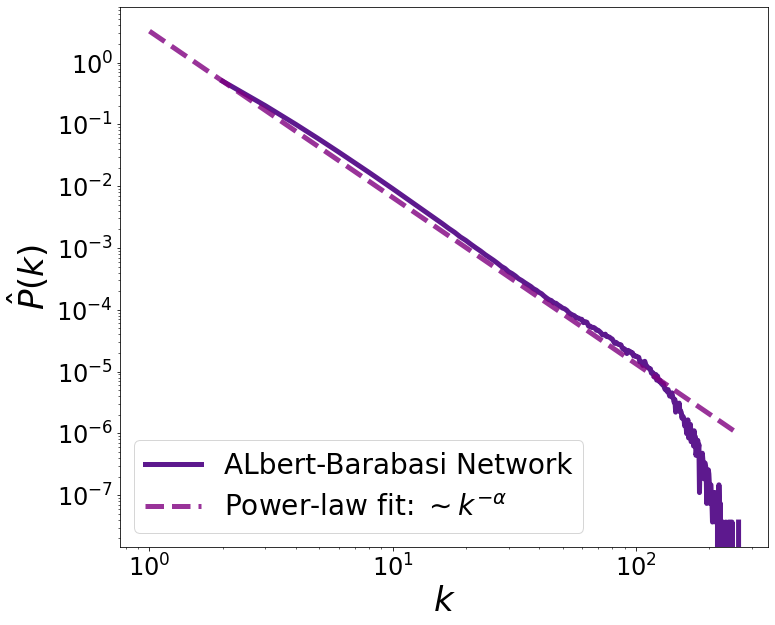

In [84]:
fig, ax = plt.subplots(figsize=(12,10), gridspec_kw={'bottom': 0.13,'left':.15})
ax.plot(k[1:], p_k[1:], marker = '', ms = '13', ls = '-', color = 'indigo', lw = 5, alpha = .9, label = 'ALbert-Barabasi Network')
popt, potv = curve_fit(my_linear_function, np.log(k[1:-150][p_k[1:-150]!=0]), np.log(p_k[1:-150][p_k[1:-150]!=0]))
ax.plot(k[:], (k[:].astype(float)**(popt[1]))*((p_k[1:][0])/(k[1:].astype(float)**(popt[1]))[0]), marker = '', ms = '12', ls = '--', color = 'purple', lw = 5, alpha = .8, label = r'Power-law fit: $\sim k^{-\alpha}$')
my_plot_layout(ax = ax, yscale = 'log', xscale = 'log', xlabel= r'$k$', ylabel= r'$\hat{P}(k)$', x_fontsize = 34, y_fontsize = 34)
ax.legend(fontsize = 28, loc = 3)
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/pdfs/Degree_distribution.pdf')
fig.savefig('../Figures/Stochastic/Networks/barabasi-albert/Degree_distribution.png')
